**BUSINESS PROBLEM OVERVIEW**


The business problem is to ensure a stable supply of rental bikes in urban cities by predicting the demand for bikes at each hour. By providing a stable supply of rental bikes, the system can enhance mobility comfort for the public and reduce waiting time, leading to greater customer satisfaction.

To address this problem, we need to develop a predictive model that takes into account various factors that may influence demand, such as time of day, seasonality, weather conditions, and holidays. By accurately predicting demand, the bike sharing system operators can ensure that there is an adequate supply of bikes available at all times, which can improve the user experience and increase usage of the bike sharing system. This can have a positive impact on the sustainability of urban transportation, as it can reduce congestion, air pollution, and greenhouse gas emissions.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

!pip install shap==0.19.2
import shap
import graphviz

import pickle


pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid",{'grid.linestyle': '--'})

The Seoul Bike Sharing Demand dataset contains information about bike rental in Seoul from 2017-2018. It includes hourly observations of 14 columns, such as the date, time, number of rented bikes, weather conditions, and other factors that may influence bike rental demand.

This dataset contains more than 8000 rows and 14 columns of the data.

*   **Date**: The date of the observation.
*   **Rented Bike Count**: The number of bikes rented during the observation period.
*   **Hour**: The hour of the day when the observation was taken.
*   **Temperature(°C)**: The temperature in Celsius at the time of observation.
*   **Humidity(%)**: The percentage of humidity at the time of observation.
*   **Wind speed (m/s)**: The wind speed in meters per second at the time of observation.
*   **Visibility (10m)**: The visibility in meters at the time of observation.
*   **Dew point temperature(°C)**: The dew point temperature in Celsius at the time of observation.
*   **Solar Radiation (MJ/m2)**: The amount of solar radiation in mega-joules per square meter at the time of observation.
*   **Rainfall(mm)**: The amount of rainfall in millimeters during the observation period.
*   **Snowfall(cm)**: The amount of snowfall in centimeters during the observation period.
*   **Seasons**: The season of the year when the observation was taken.
*   **Holiday**: Whether the observation was taken on a holiday or not.
*   **Functioning Day**: Whether the bike sharing system was operating normally or not during the observation period.

In [ ]:
# Load Dataset
data = pd.read_csv("BikeData.csv", encoding="latin")
data.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1                      0.0           0.0            0.0  Winter  No Holiday   
2                      0.0           0.0            0.0  Winter  No Holiday   
3                      0.0           0.0            0.0  Winter  No Holiday   
4                      0.0           0.0            0.0  Winter  No Holiday   

  Functioning Day  
0             Yes  
1             Yes  
2             Yes  
3             Yes  
4             Yes

In [ ]:
data.shape

(8760, 14)

In [ ]:
data = data[['Date', 'Hour', 'Temperature(°C)', 'Humidity(%)','Wind speed (m/s)', 'Visibility (10m)',
            'Dew point temperature(°C)','Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
            'Seasons','Holiday', 'Functioning Day','Rented Bike Count']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   float64
 8   Rainfall(mm)               8760 non-null   float64
 9   Snowfall (cm)              8760 non-null   float64
 10  Seasons                    8760 non-null   object 
 11  Holiday                    8760 non-null   object 
 12  Functioning Day            8760 non-null   object 
 13  Rented Bike Count          8760 non-null   int64

In [ ]:
data.describe().T

count         mean         std   min     25%  \
Hour                       8760.0    11.500000    6.922582   0.0    5.75   
Temperature(°C)            8760.0    12.882922   11.944825 -17.8    3.50   
Humidity(%)                8760.0    58.226256   20.362413   0.0   42.00   
Wind speed (m/s)           8760.0     1.724909    1.036300   0.0    0.90   
Visibility (10m)           8760.0  1436.825799  608.298712  27.0  940.00   
Dew point temperature(°C)  8760.0     4.073813   13.060369 -30.6   -4.70   
Solar Radiation (MJ/m2)    8760.0     0.569111    0.868746   0.0    0.00   
Rainfall(mm)               8760.0     0.148687    1.128193   0.0    0.00   
Snowfall (cm)              8760.0     0.075068    0.436746   0.0    0.00   
Rented Bike Count          8760.0   704.602055  644.997468   0.0  191.00   

                               50%      75%      max  
Hour                         11.50    17.25    23.00  
Temperature(°C)              13.70    22.50    39.40  
Humidity(%)                  57.00    74.00    98.00  
Wind speed (m/s)              1.50     2.30     7.40  
Visibility (10m)           1698.00  2000.00  2000.00  
Dew point temperature(°C)     5.10    14.80    27.20  
Solar Radiation (MJ/m2)       0.01     0.93     3.52  
Rainfall(mm)                  0.00     0.00    35.00  
Snowfall (cm)                 0.00     0.00     8.80  
Rented Bike Count           504.50  1065.25  3556.00

In [ ]:
data.isna().sum()

Date                         0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Rented Bike Count            0
dtype: int64

In [ ]:
# Dataset Duplicate Value Count
data[data.duplicated()].shape[0]

0

In [ ]:
data.columns

Index(['Date', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Rented Bike Count'],
      dtype='object')

In [ ]:
# Check Unique Values for each variable.
for i in data.columns.tolist():
  print("No. of unique values in ",i,"is : ",data[i].nunique())

No. of unique values in  Date is :  365
No. of unique values in  Hour is :  24
No. of unique values in  Temperature(°C) is :  546
No. of unique values in  Humidity(%) is :  90
No. of unique values in  Wind speed (m/s) is :  65
No. of unique values in  Visibility (10m) is :  1789
No. of unique values in  Dew point temperature(°C) is :  556
No. of unique values in  Solar Radiation (MJ/m2) is :  345
No. of unique values in  Rainfall(mm) is :  61
No. of unique values in  Snowfall (cm) is :  51
No. of unique values in  Seasons is :  4
No. of unique values in  Holiday is :  2
No. of unique values in  Functioning Day is :  2
No. of unique values in  Rented Bike Count is :  2166


In [ ]:
# Create a copy of the current dataset and assigning to df
df = data.copy()

In [ ]:
# Changing the "Date" column dtype to datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

In [ ]:
# Creating new columns Year, Month, Day
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.day_name()  # we better understand names (monday, friday etc) instead of numbers

In [ ]:
# Changing Hour, Year, Month dtypes to categorical
for col in ['Year', 'Month', 'Day']:
  df[col] = df[col].astype('category')

In [ ]:
# Creating Temperature bin of 1°C intervals that will help in visualizations
df['Temperature Bin'] = df['Temperature(°C)'].round(0).astype('int64')

In [ ]:
# Unique hours
df['Hour'].unique()    # It is in 24hrs format

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## **Exploratory Data Analysis**

### **Non-Graphical Data Analysis**

In [ ]:
# Year wise Rented Bike Count
df.groupby('Year')['Rented Bike Count'].describe()

count        mean         std  min     25%    50%     75%     max
Year                                                                    
2017   744.0  249.099462  158.396544  3.0  131.75  236.5   329.0   937.0
2018  8016.0  746.879242  656.708588  0.0  206.00  586.0  1117.0  3556.0

In [ ]:
# weekday wise Rented Bike Count
df.groupby('weekday')['Rented Bike Count'].describe()

count        mean         std  min     25%    50%      75%     max
weekday                                                                       
Friday     1272.0  747.117925  658.396481  0.0  233.00  566.0  1115.25  3365.0
Monday     1248.0  730.563301  664.960809  2.0  186.00  533.0  1099.00  3380.0
Saturday   1248.0  709.528846  603.913165  0.0  219.00  519.0  1076.00  2497.0
Sunday     1248.0  625.155449  605.529274  0.0  158.75  406.0   936.50  2514.0
Thursday   1248.0  690.704327  641.675659  0.0  185.00  495.0  1049.00  3418.0
Tuesday    1248.0  687.977564  652.165697  0.0  179.50  485.5  1031.50  3556.0
Wednesday  1248.0  740.349359  677.573675  0.0  206.75  536.5  1107.25  3384.0

In [ ]:
# Season wise Rented Bike Count
df.groupby('Seasons')['Rented Bike Count'].describe()

count         mean         std  min     25%    50%      75%     max
Seasons                                                                      
Autumn   2184.0   819.597985  651.085621  0.0  241.75  763.5  1197.50  3298.0
Spring   2208.0   730.031250  621.509635  0.0  206.00  583.0  1105.25  3251.0
Summer   2208.0  1034.073370  690.244759  9.0  526.75  905.5  1442.50  3556.0
Winter   2160.0   225.541204  150.372236  3.0  110.00  203.0   305.00   937.0

In [ ]:
# Holiday wise Rented Bike Count
df.groupby('Holiday')['Rented Bike Count'].describe()

count        mean         std  min     25%    50%     75%     max
Holiday                                                                       
Holiday      432.0  499.756944  570.772769  0.0  105.75  240.0   762.5  2400.0
No Holiday  8328.0  715.228026  646.879124  0.0  200.00  524.5  1073.0  3556.0

In [ ]:
# Functioning Day wise Rented Bike Count
df.groupby('Functioning Day')['Rented Bike Count'].describe()

count        mean         std  min    25%    50%     75%  \
Functioning Day                                                              
No                295.0    0.000000    0.000000  0.0    0.0    0.0     0.0   
Yes              8465.0  729.156999  642.351166  2.0  214.0  542.0  1084.0   

                    max  
Functioning Day          
No                  0.0  
Yes              3556.0

In [ ]:
# Statistical properties of Rented Bike Count
df['Rented Bike Count'].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Rented Bike Count, dtype: float64

### **Graphical Analysis**

Text(0.5, 1.0, 'Box Plot for Rented Bike Count')

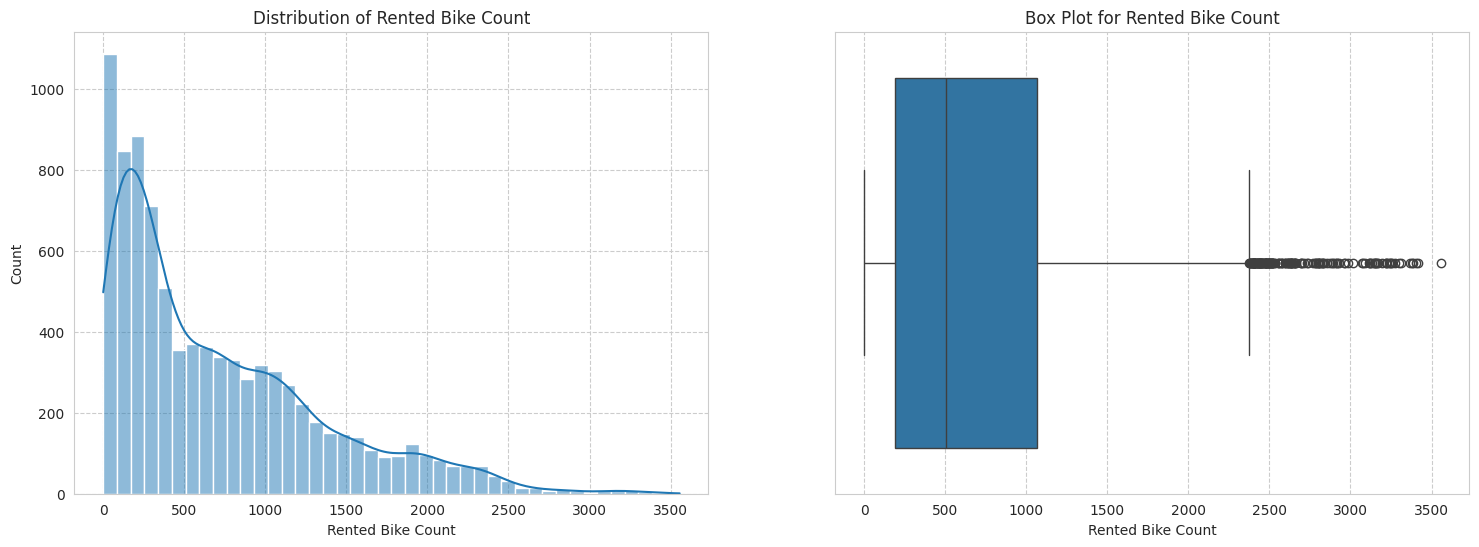

In [ ]:
#  Histogram & Box-plot for distribution of Rented Bike Count
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.histplot(x='Rented Bike Count', data=df, kde=True)
plt.title("Distribution of Rented Bike Count")

plt.subplot(1,2,2)
sns.boxplot(x='Rented Bike Count', data = df)
plt.title("Box Plot for Rented Bike Count")

Rented Bike Count is right skewed. It means that most of the data falls on the lower end of the scale, and there are relatively fewer instances where a large number of bikes were rented.

## Univariate Analysis

Text(0.5, 1.0, 'Rented Bike Count by Seasons')

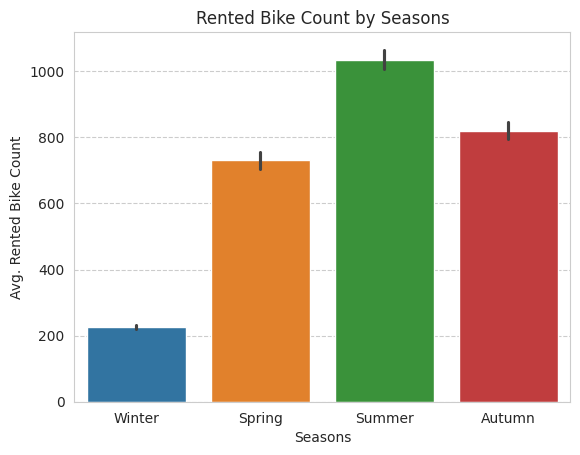

In [ ]:
# Rented Bike Count by Seasons
sns.barplot(x='Seasons', y='Rented Bike Count', data=df,hue = 'Seasons')
plt.xlabel("Seasons")
plt.ylabel("Avg. Rented Bike Count")
plt.title("Rented Bike Count by Seasons")

Rentals Bike demand is highest in summer season and lowest in winter season.

Text(0.5, 1.0, 'Rented Bike Count trend by Hour')

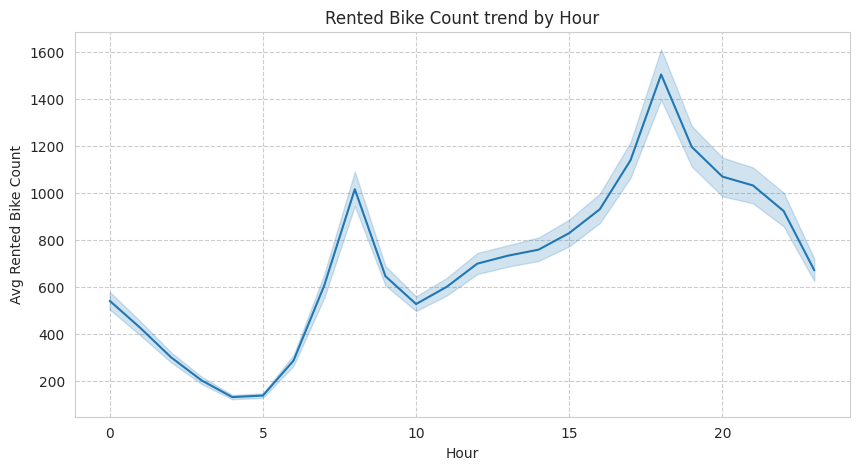

In [ ]:
# Average Rented Bike Count by Hour
plt.figure(figsize=(10,5))
sns.lineplot(x='Hour', y='Rented Bike Count', data=df)
plt.ylabel("Avg Rented Bike Count")
plt.title("Rented Bike Count trend by Hour")

The demand is higher during rush hour (i.e., 7-9AM and 5-7PM) when people go to offices/schools and come back in evening.

Text(0.5, 1.0, 'Rented Bike Count by Months')

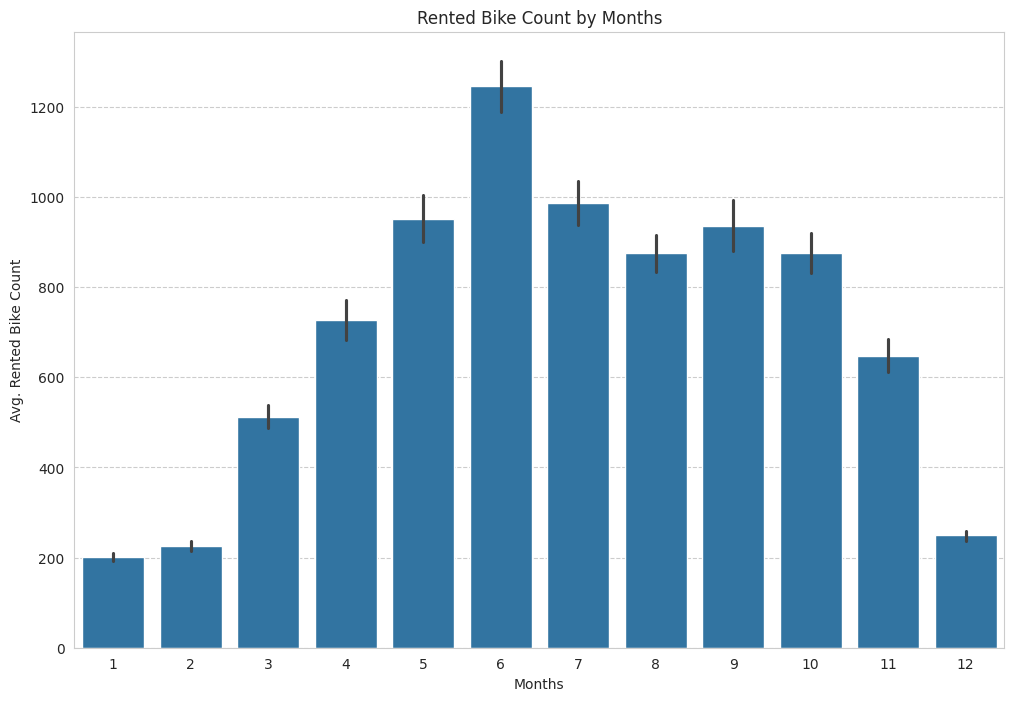

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(x='Month', y='Rented Bike Count', data=df)
plt.xlabel("Months")
plt.ylabel("Avg. Rented Bike Count")
plt.title("Rented Bike Count by Months")

Rentals Bike demand is more in summer months like May, June, Jult etc compared to winter months like December, January, February etc.

Text(0.5, 1.0, 'Rented Bike Count trend by Temperature(°C)')

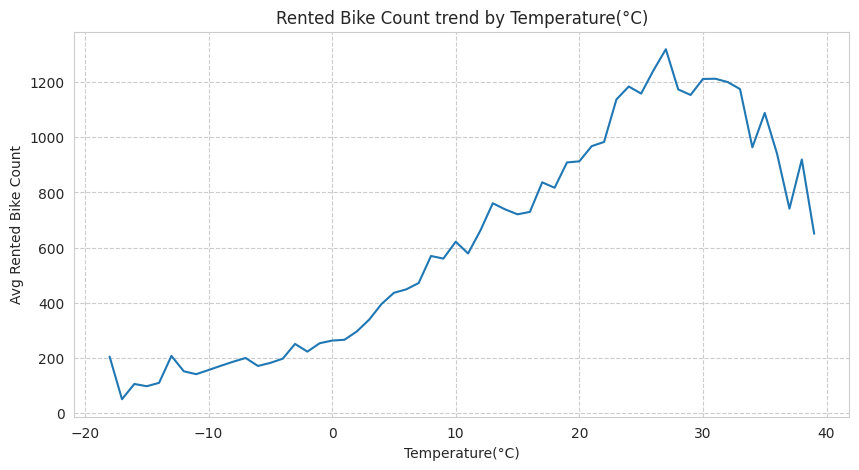

In [ ]:
plt.figure(figsize=(10,5))
df.groupby('Temperature Bin')['Rented Bike Count'].mean().plot(kind='line')
plt.ylabel("Avg Rented Bike Count")
plt.xlabel("Temperature(°C)")
plt.title("Rented Bike Count trend by Temperature(°C)")

The Rentals Bike demand increases as tempreature increases although too high temperature like above 30°C leads to decrease in demand.

Text(0.5, 1.0, 'Rented Bike Count trend by Dew point temperature(°C)')

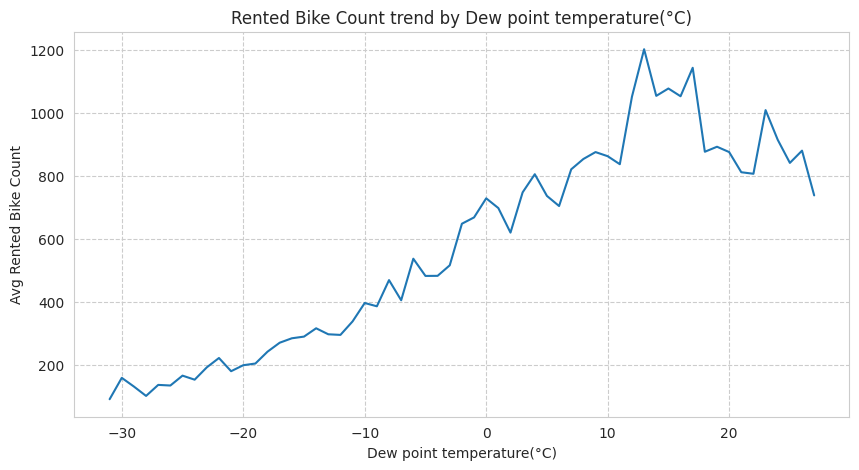

In [ ]:
d = df.copy()
d['Dew point temperature(°C) Bin'] = d['Dew point temperature(°C)'].round(0).astype('int64')

plt.figure(figsize=(10,5))
d.groupby('Dew point temperature(°C) Bin')['Rented Bike Count'].mean().plot(kind='line')
plt.ylabel("Avg Rented Bike Count")
plt.xlabel("Dew point temperature(°C)")
plt.title("Rented Bike Count trend by Dew point temperature(°C)")

Similar to trend of bike rentals demand over temperature, here also demand increases as dew point tempreature increases although too high dew point temperature like above 18°C leads to decrease in demand

Text(0, 0.5, 'Rented Bike Count')

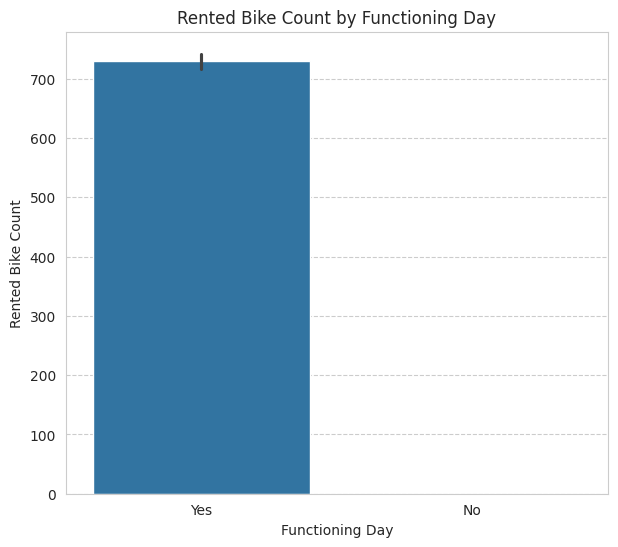

In [ ]:
plt.figure(figsize=(7,6))
sns.barplot(y='Rented Bike Count', x='Functioning Day', data=df)
plt.title("Rented Bike Count by Functioning Day")
plt.ylabel("Rented Bike Count")

On non functioning day there is no demand (because the rentals bike service is not functioning, so no one is booking).

## Bivariate Analysis

Text(0.5, 1.0, 'Rented Bike Count trend by Hour for each Seasons')

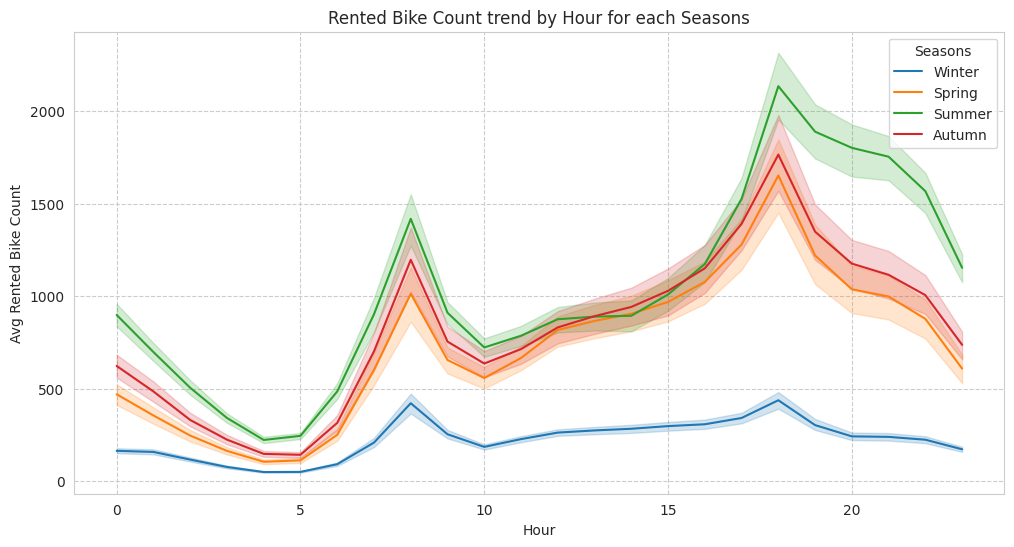

In [ ]:
# Average Rented Bike Count by Hour for each Seasons
plt.figure(figsize=(12,6))
sns.lineplot(x="Hour", y="Rented Bike Count", hue="Seasons", data=df)
plt.ylabel("Avg Rented Bike Count")
plt.title("Rented Bike Count trend by Hour for each Seasons")

The Rentals Bike demand trend pattern is same for all the seasons only levels are different. Demand level in winter is lowest and highest in Summer

Text(0.5, 1.0, 'Rented Bike Count by Snowfall (cm)')

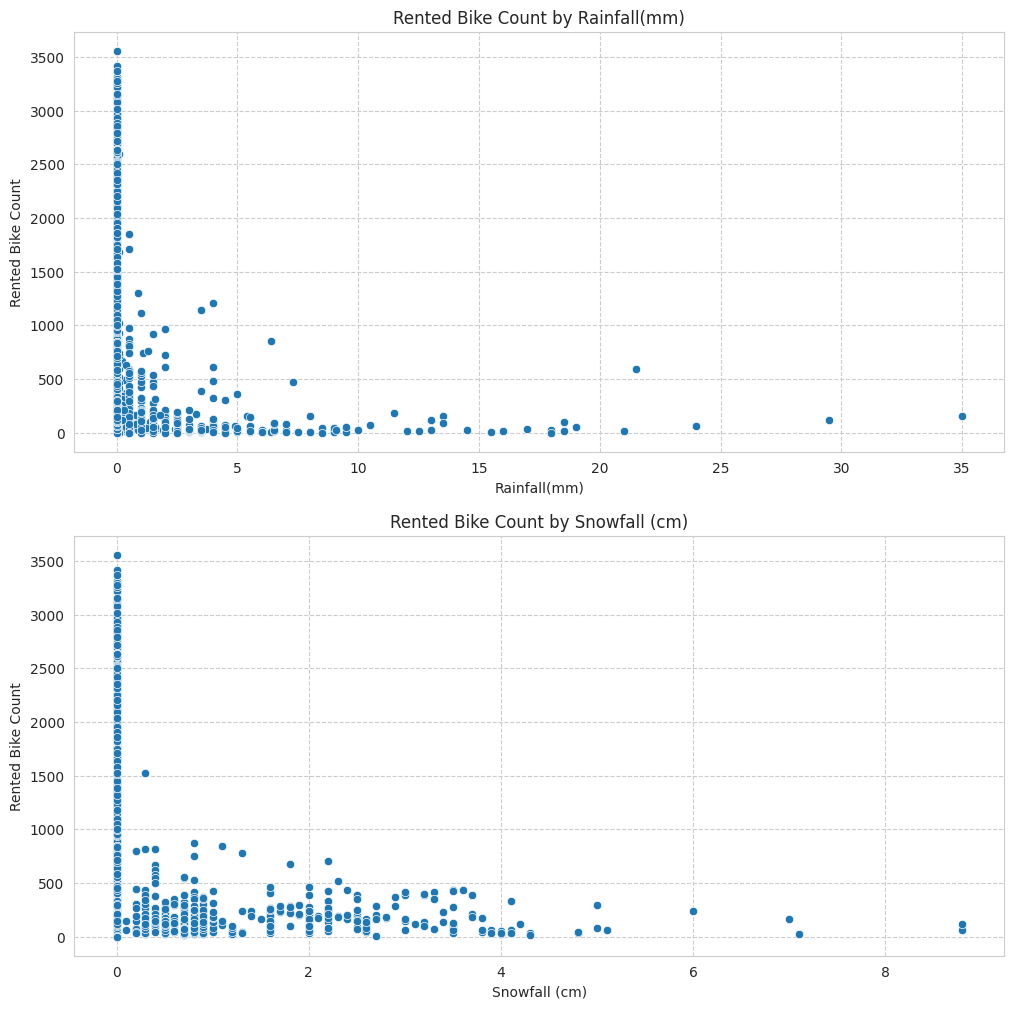

In [ ]:
# Rented Bike Demand by Rainfall & Snowfall
plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
sns.scatterplot(x='Rainfall(mm)', y='Rented Bike Count', data=df)
plt.title("Rented Bike Count by Rainfall(mm)")

plt.subplot(2,1,2)
sns.scatterplot(x='Snowfall (cm)', y='Rented Bike Count', data=df)
plt.title("Rented Bike Count by Snowfall (cm)")

Most Rentals Bikes are rented mostly when there is 0 rainfall and snowfall. As Rainfall and snowfall increases demand decreases.

Text(0, 0.5, 'Avg Rented Bike Count')

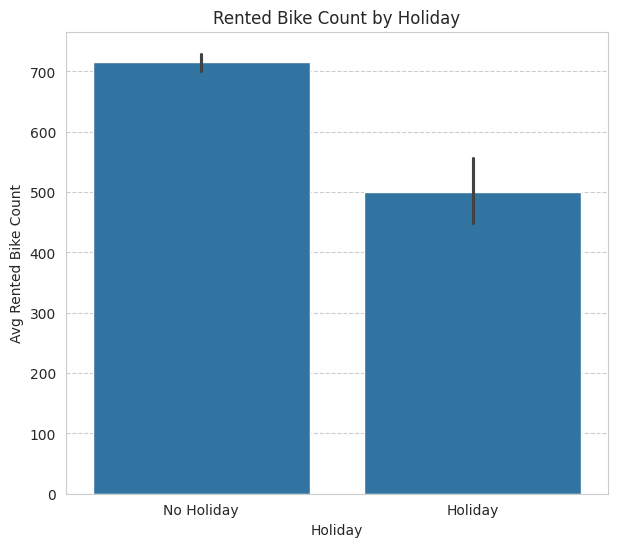

In [ ]:
# Avg Rented Bike Count by Holiday
plt.figure(figsize=(7,6))
sns.barplot(y='Rented Bike Count', x='Holiday', data=df)
plt.title("Rented Bike Count by Holiday")
plt.ylabel("Avg Rented Bike Count")

Non holidays have more demand compared to holidays maybe because alot of people uses rentals bike for going to offices/schools on non holidays.

Text(0.5, 1.0, 'Solar Radiation (MJ/m2) by Date for each Year')

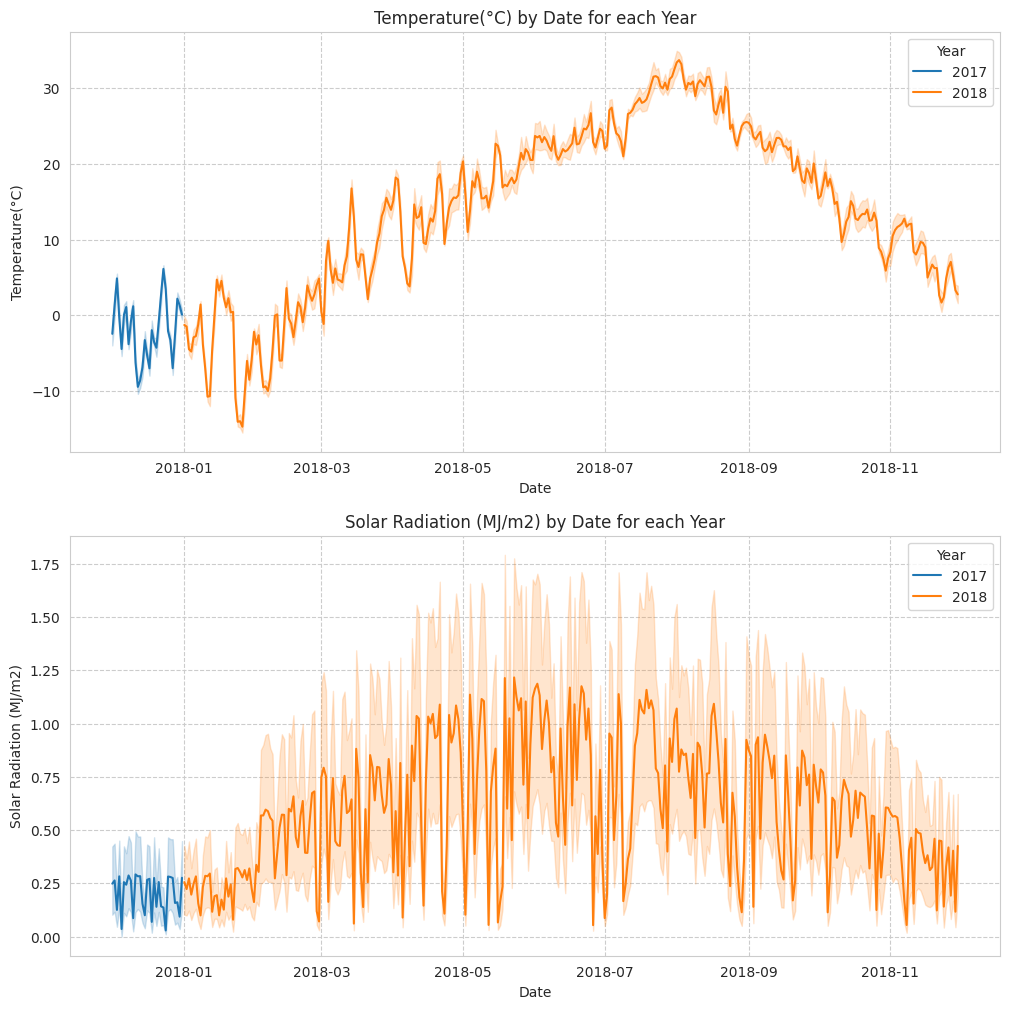

In [ ]:
# Temperature and Solar Radiation over time
plt.figure(figsize=(12, 12))

# Plot temperature
plt.subplot(2, 1, 1)
sns.lineplot(x='Date', y='Temperature(°C)', hue='Year', data=df)
plt.ylabel('Temperature(°C)')
plt.title("Temperature(°C) by Date for each Year")

# Plot humidity
plt.subplot(2, 1, 2)
sns.lineplot(x='Date', y='Solar Radiation (MJ/m2)', hue='Year', data=df)
plt.ylabel('Solar Radiation (MJ/m2)')
plt.title("Solar Radiation (MJ/m2) by Date for each Year")

As expected temperature rises during summer months and lowers in winter months.

Similarly solar radiation is more in summer months copared to winter months, also huge fluctuations in solar radiation may be caused due to day-night cycle as there is no sunlight at night time.

Text(0.5, 1.0, 'Avg Rented Bike Count by Wind speed (m/s)')

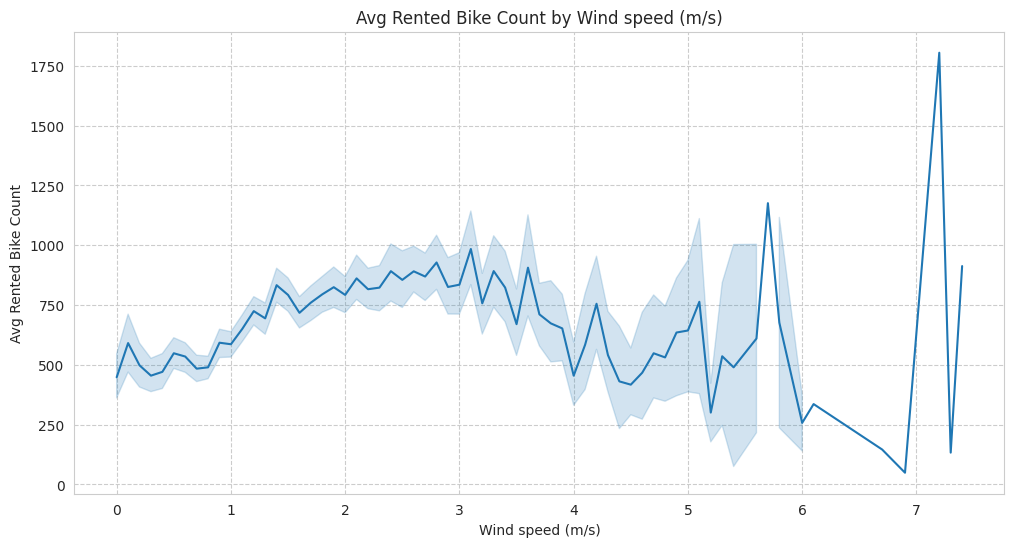

In [ ]:
# Avg Rented Bike Count by Wind speed (m/s)
plt.figure(figsize=(12,6))
sns.lineplot(x='Wind speed (m/s)', y='Rented Bike Count', data=df)
plt.ylabel("Avg Rented Bike Count")
plt.title("Avg Rented Bike Count by Wind speed (m/s)")

Initially wind speed increases, the demand increases since flowing air creates better weather and less heat, although too high wind speed created storm and all so too high speed leads to decreases in demand.

Text(0.5, 1.0, 'Avg Rented Bike Count by Humidity(%)')

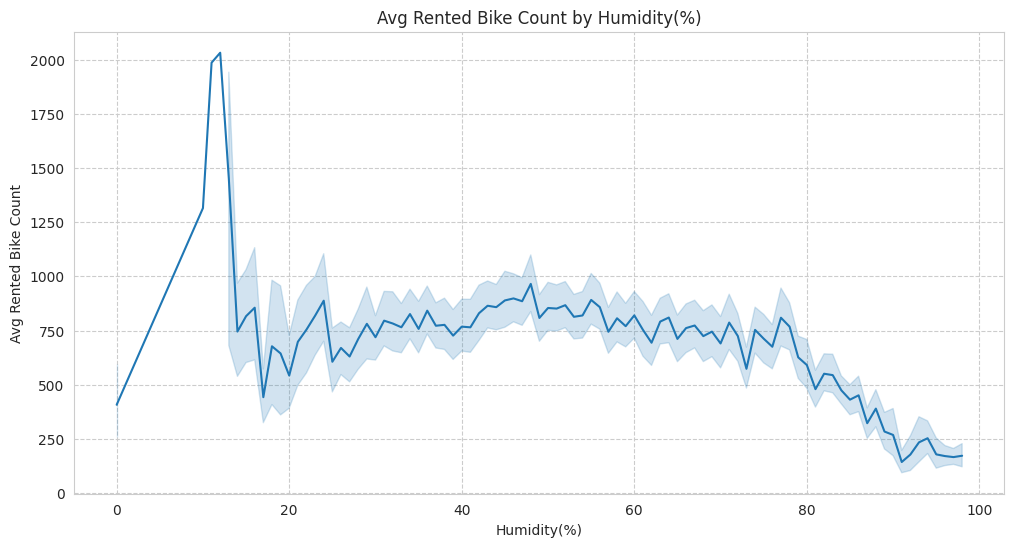

In [ ]:
# Avg Rented Bike Count by Humidity (%)
plt.figure(figsize=(12,6))
sns.lineplot(x='Humidity(%)', y='Rented Bike Count', data=df)
plt.ylabel("Avg Rented Bike Count")
plt.title("Avg Rented Bike Count by Humidity(%)")

After certain level as humidity increases demand decreases as too much humidity may generally caused due to rain or snowfall as we already saw they leads to decrease in demand.

Text(0.5, 1.0, 'Rented Bike Count by Visibility (10m)')

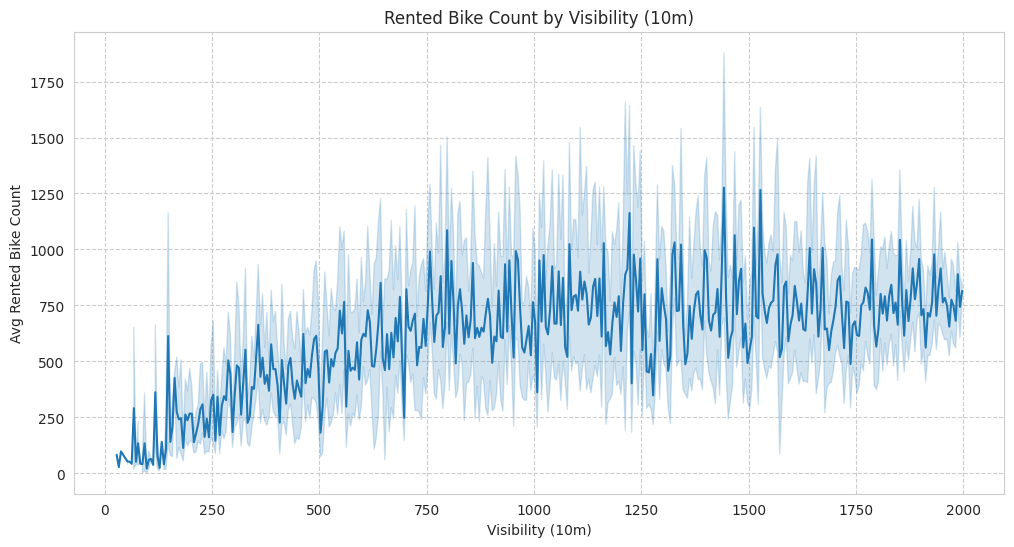

In [ ]:
# Rented Bike Count trend by Visibility

d = df.copy()
# Create bins of width 5 for the "Visibility (10m)" variable
bins = range(0, 2005, 5)

# Add a new column to the dataframe containing the bin labels
d['Visibility (10m) bin'] = pd.cut(d['Visibility (10m)'], bins=bins, include_lowest=True)
# Replacing bins with their mid values for better visualization axis labels
d['Visibility (10m) bin'] = d['Visibility (10m) bin'].apply(lambda x: x.mid)

plt.figure(figsize=(12,6))
sns.lineplot(x='Visibility (10m) bin', y='Rented Bike Count', data=d)
plt.xlabel('Visibility (10m)')
plt.ylabel('Avg Rented Bike Count')
plt.title("Rented Bike Count by Visibility (10m)")

As visibility increases rented bike demand increases which is obvious as people like to go out on clear day not on foggy day. Although after certain level no matter visibility increases demand remains consistent.

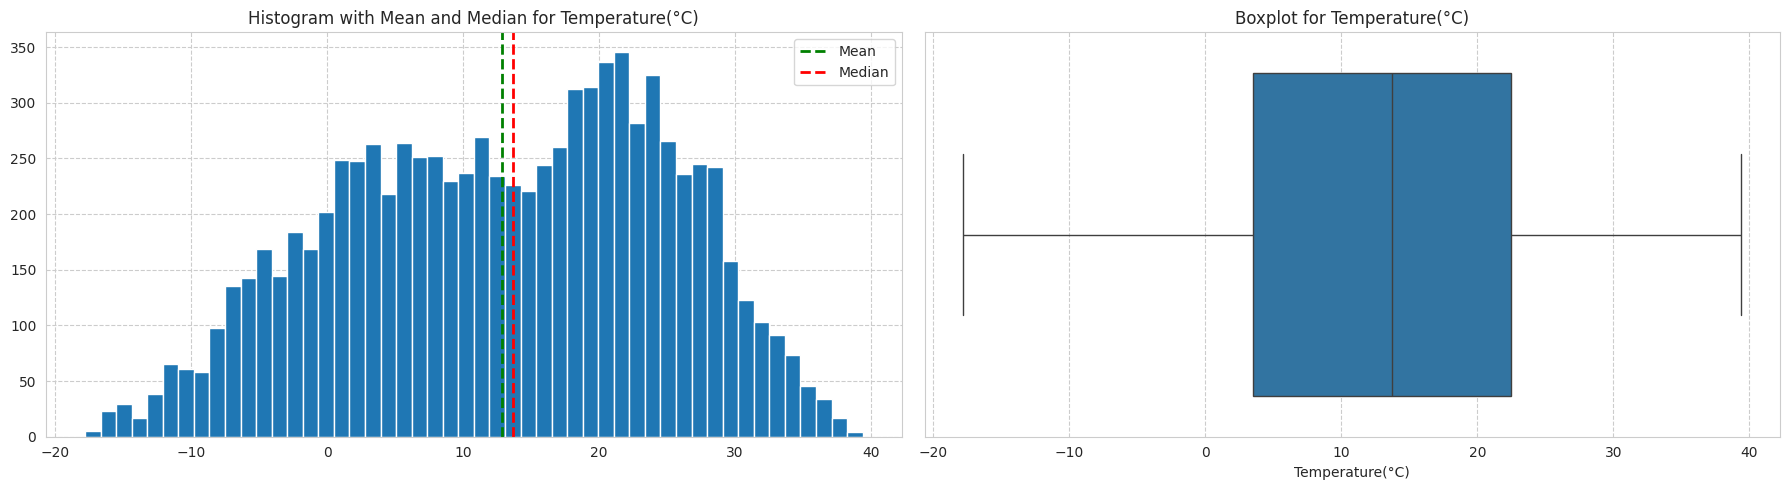

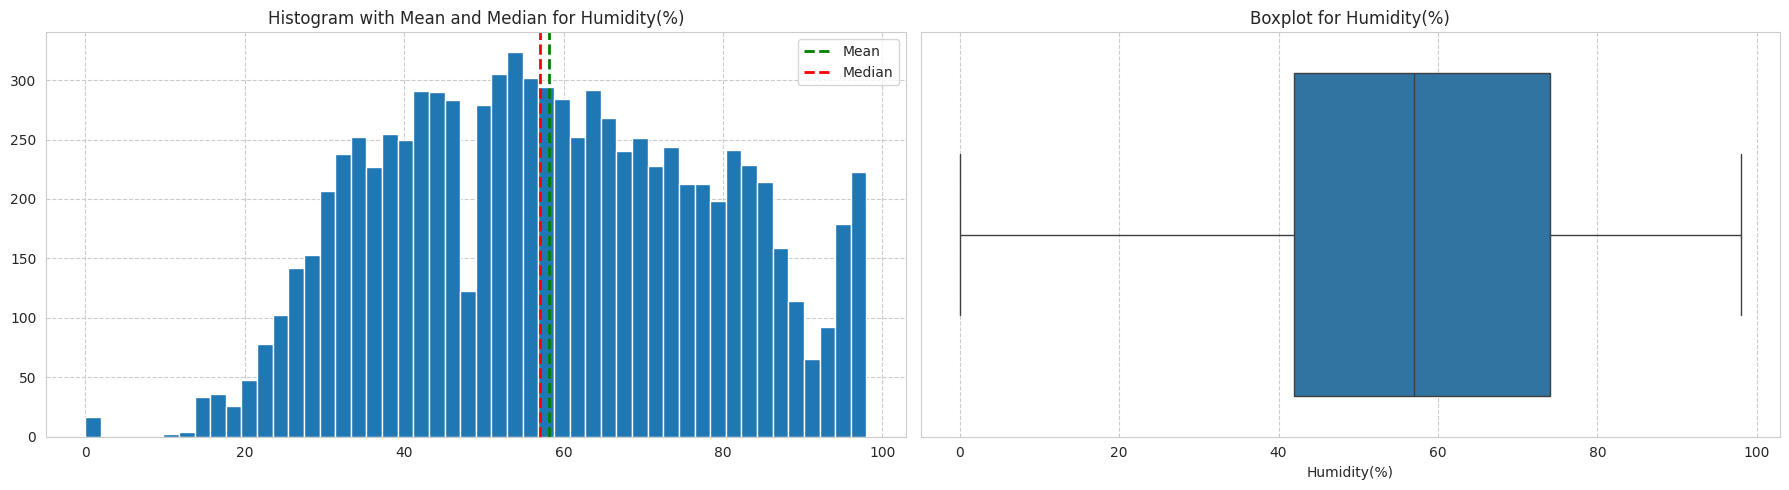

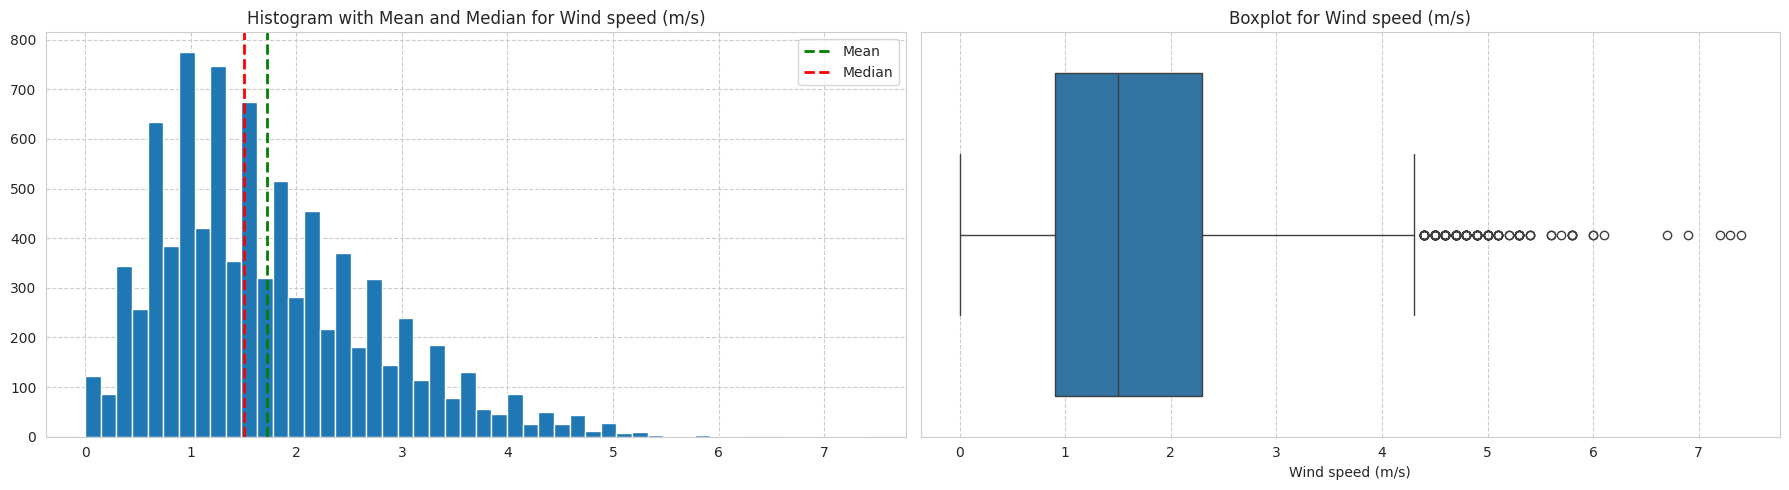

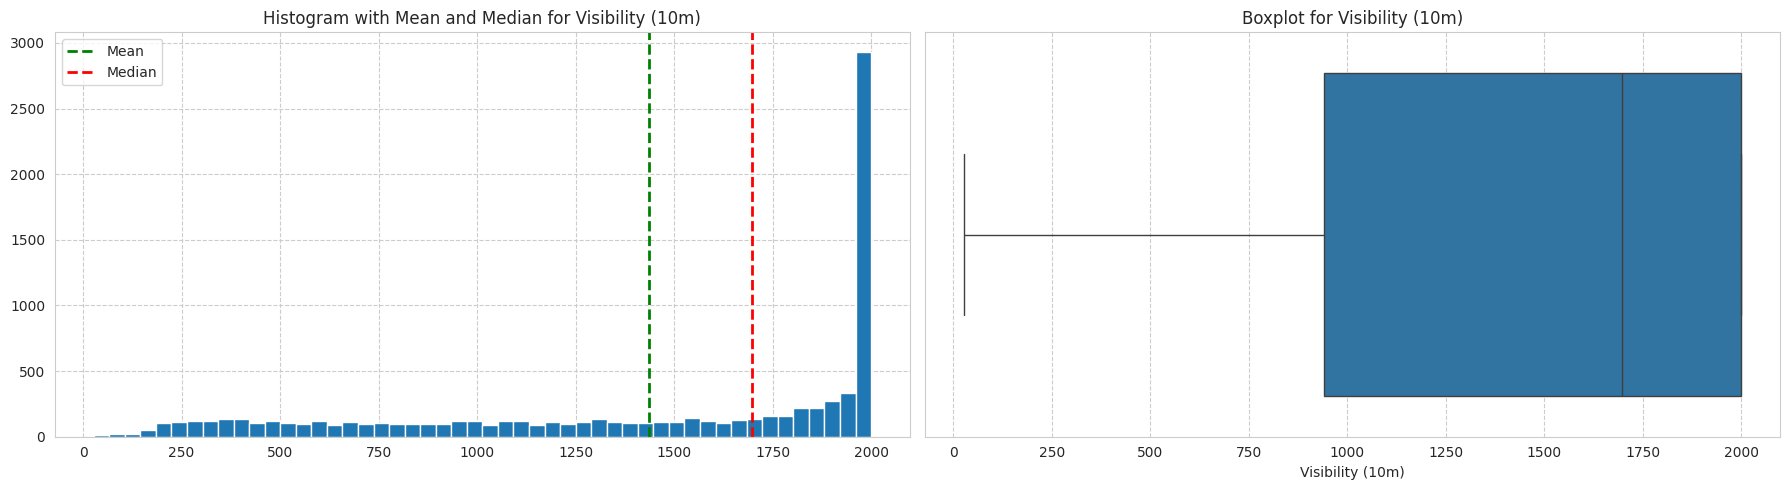

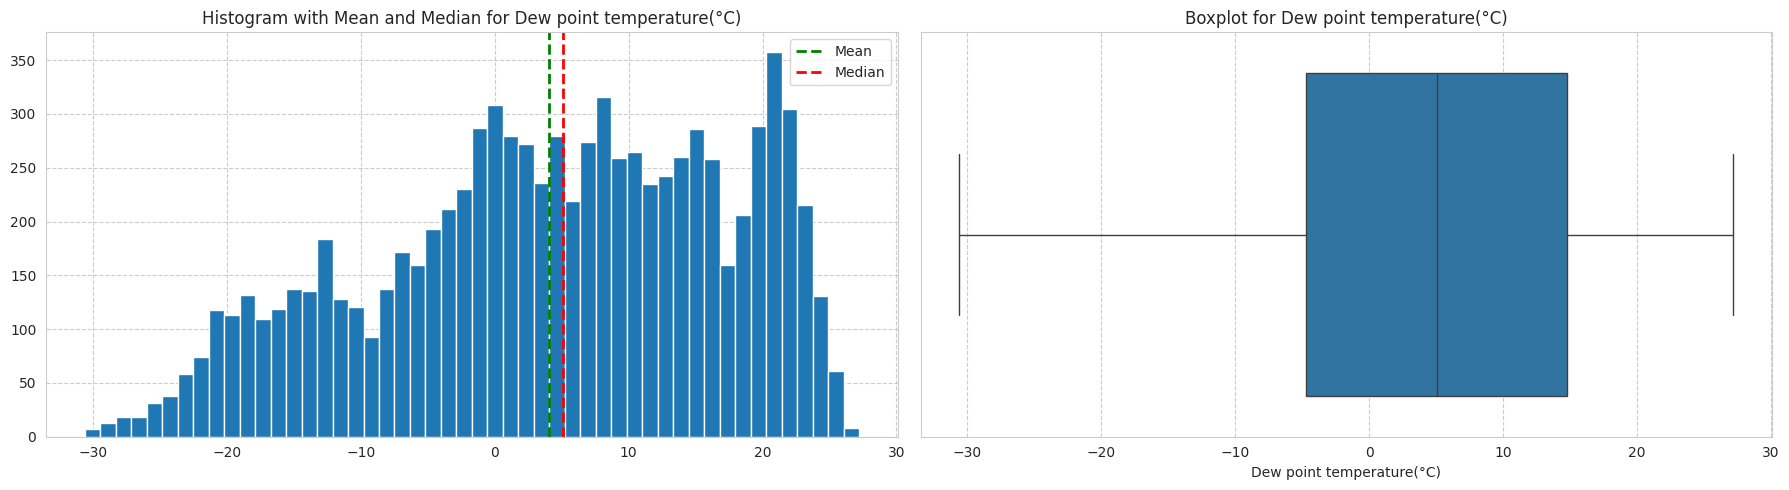

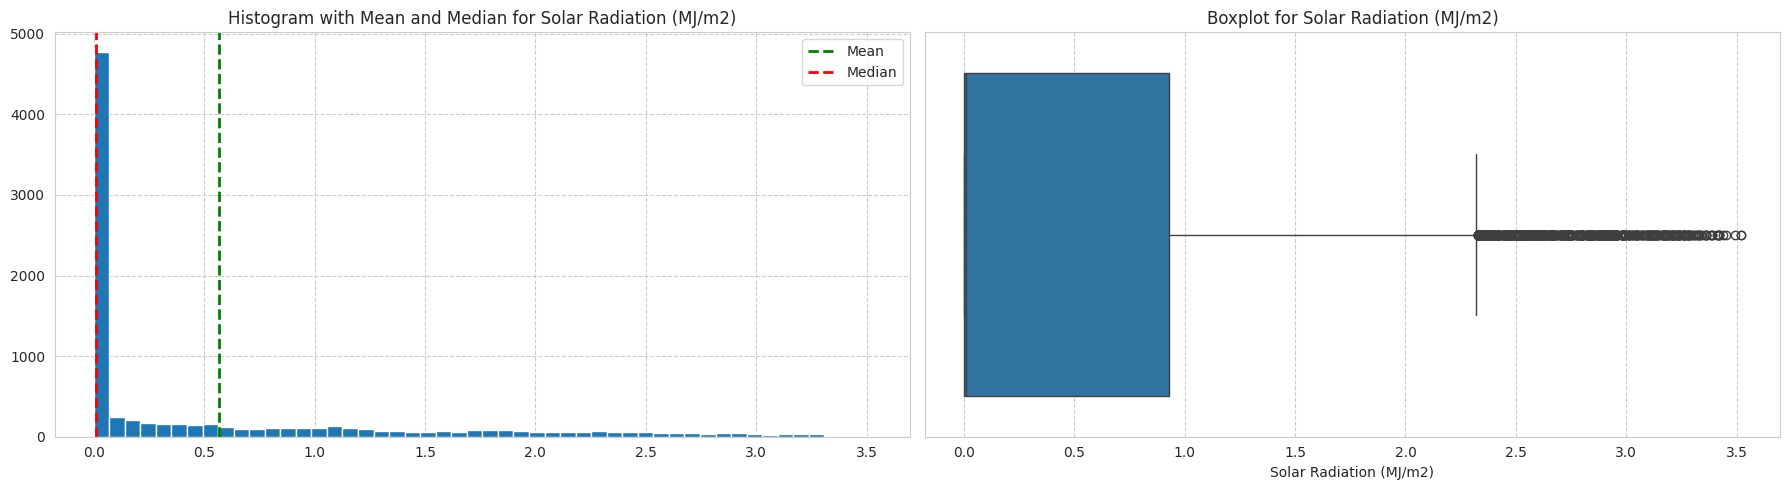

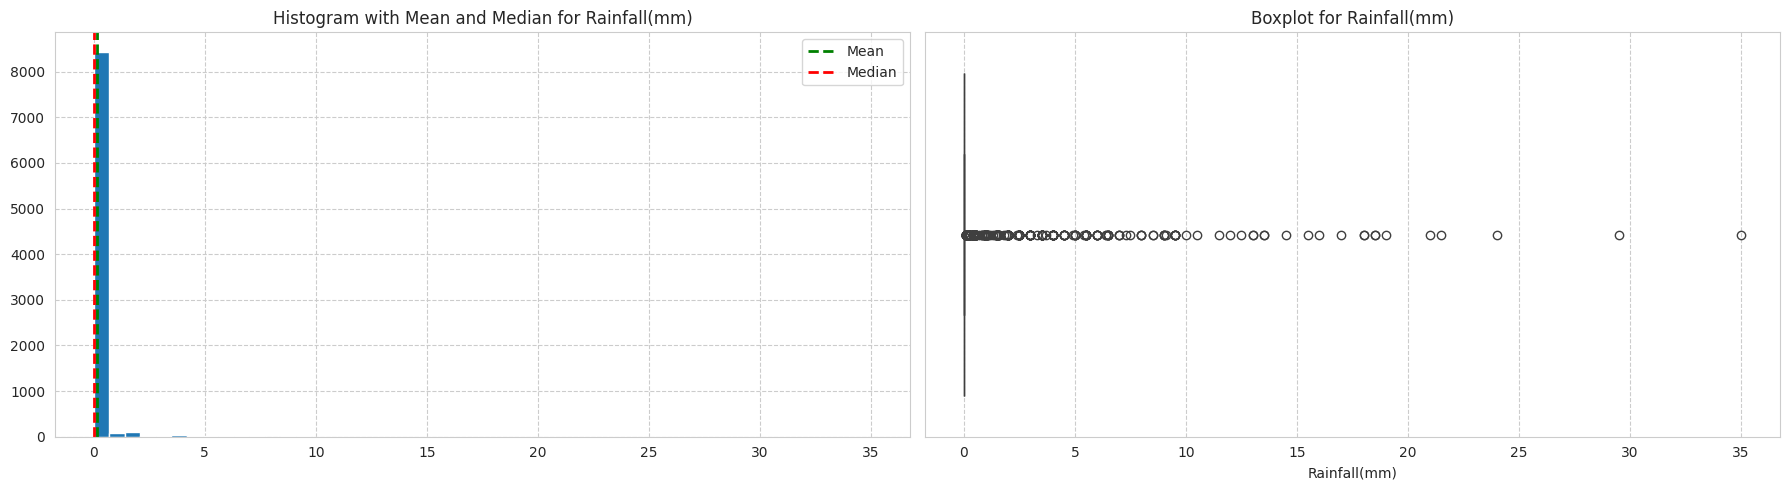

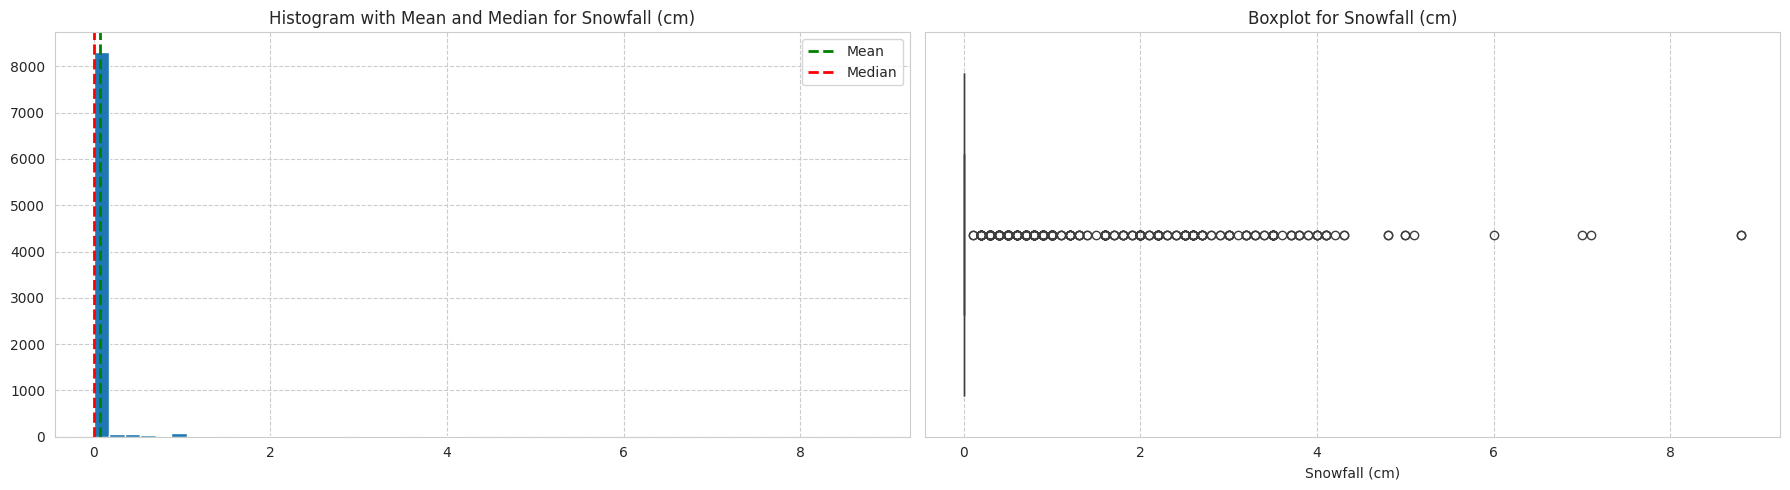

In [ ]:
# Numeric features
numeric_features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                     'Visibility (10m)', 'Dew point temperature(°C)',
                     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

# Plotting histograms, distplots, and boxplots
n = 1
for i in numeric_features:
    plt.figure(figsize=(18, 5))

    # Histogram with mean and median
    plt.subplot(1, 2, 1)
    df[i].hist(bins=50)
    plt.axvline(df[i].mean(), color='green', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(df[i].median(), color='red', linestyle='dashed', linewidth=2, label='Median')
    plt.title(f'Histogram with Mean and Median for {i}')
    plt.legend()



    # Boxplot
    plt.subplot(1,2, 2)
    sns.boxplot(x=df[i])
    plt.title(f'Boxplot for {i}')

    plt.tight_layout()
    plt.show()

Temperature, Dew Point Temperature and Humidity are approx normally distributed and rest are not.

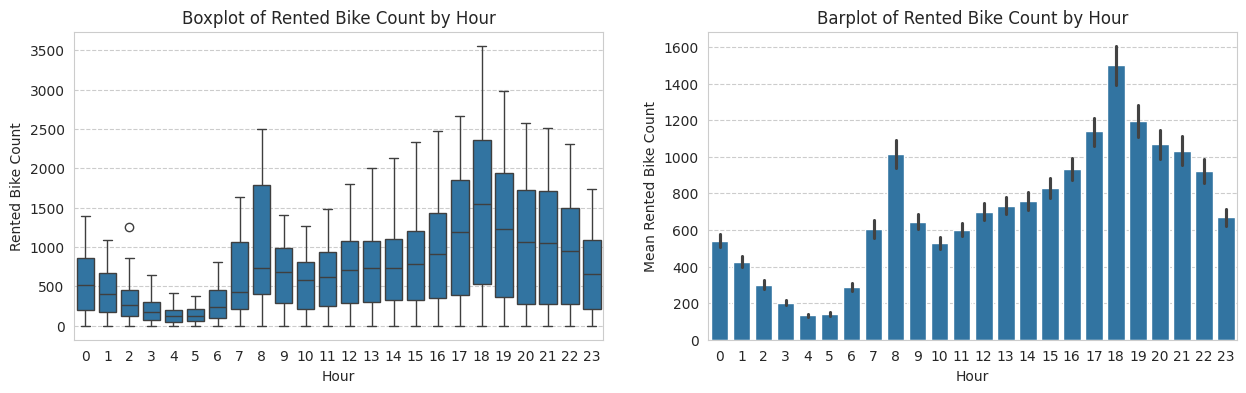

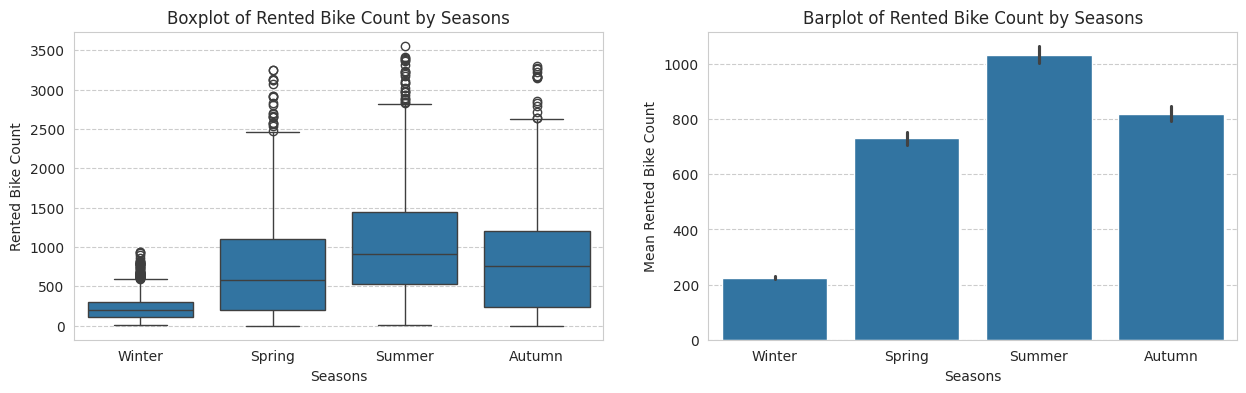

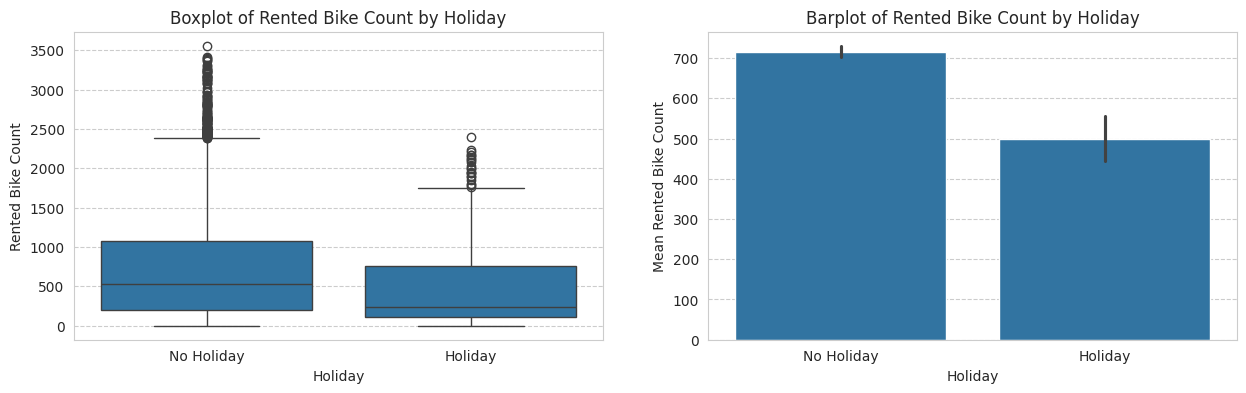

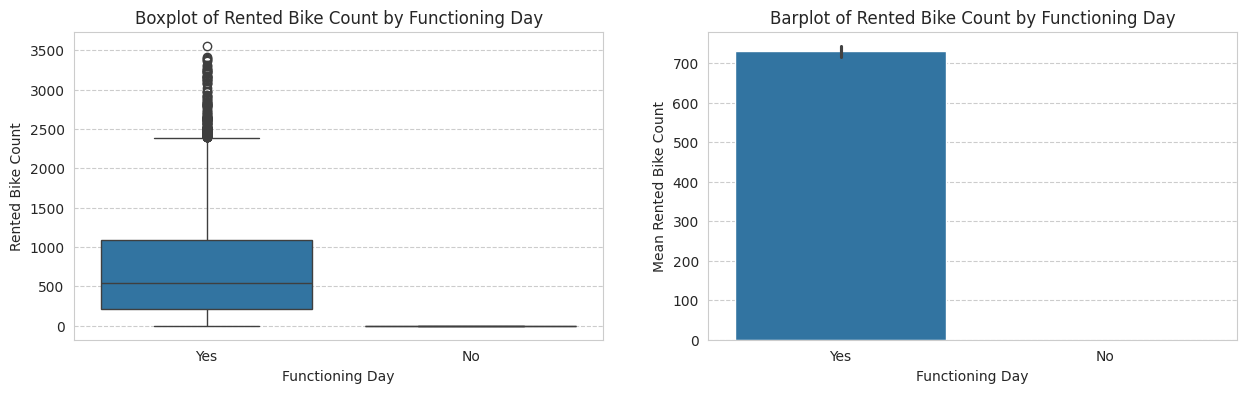

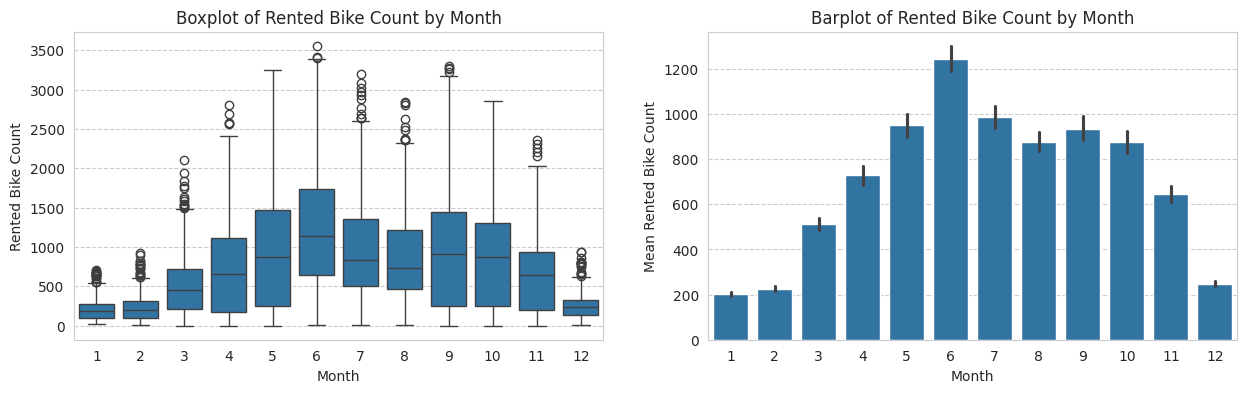

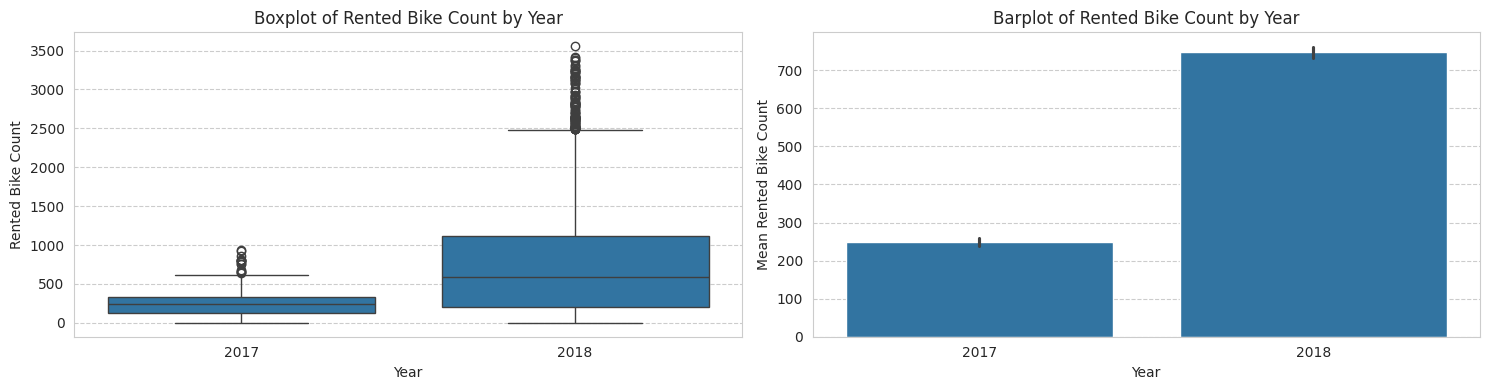

In [ ]:
categorical_features = ['Hour', 'Seasons', 'Holiday', 'Functioning Day', 'Month', 'Year']

for feature in categorical_features:
    plt.figure(figsize=(15, 4))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feature], y=df["Rented Bike Count"],)
    plt.title(f'Boxplot of Rented Bike Count by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Rented Bike Count')

    # Barplot
    plt.subplot(1, 2, 2)
    sns.barplot(x=df[feature], y=df['Rented Bike Count'])  # Set ci=None to remove error bars
    plt.title(f'Barplot of Rented Bike Count by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Mean Rented Bike Count')

plt.tight_layout()
plt.show()

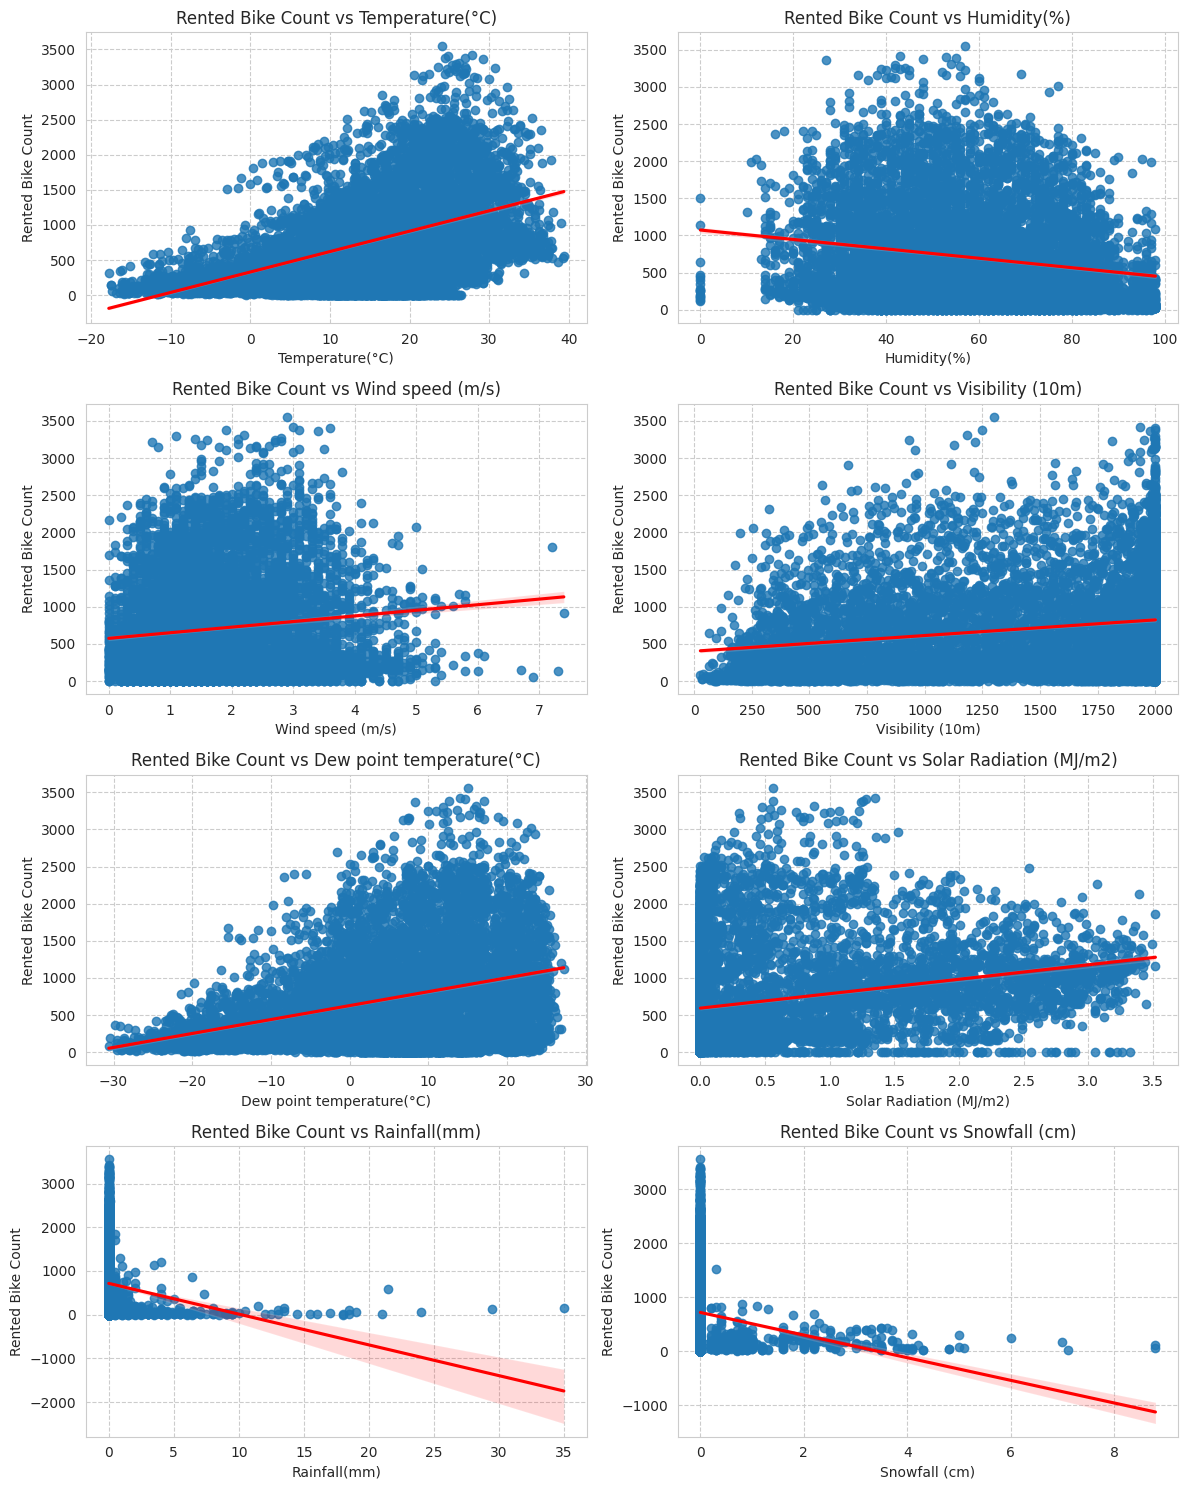

In [ ]:
# Regression plots for relation with the independent variable
numeric_features = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
                     'Visibility (10m)', 'Dew point temperature(°C)',
                     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)','Rented Bike Count']
n = 1
plt.figure(figsize=(12, 15))
for i in numeric_features:
    if i == 'Rented Bike Count':
        pass
    else:
        plt.subplot(4, 2, n)
        n += 1
        sns.regplot(x= df[i], y= df['Rented Bike Count'], line_kws={"color": "red"})
        plt.title(f'Rented Bike Count vs {i}')

# Adjust the layout of the entire figure
plt.tight_layout()

# Show the plots
plt.show()

<Axes: >

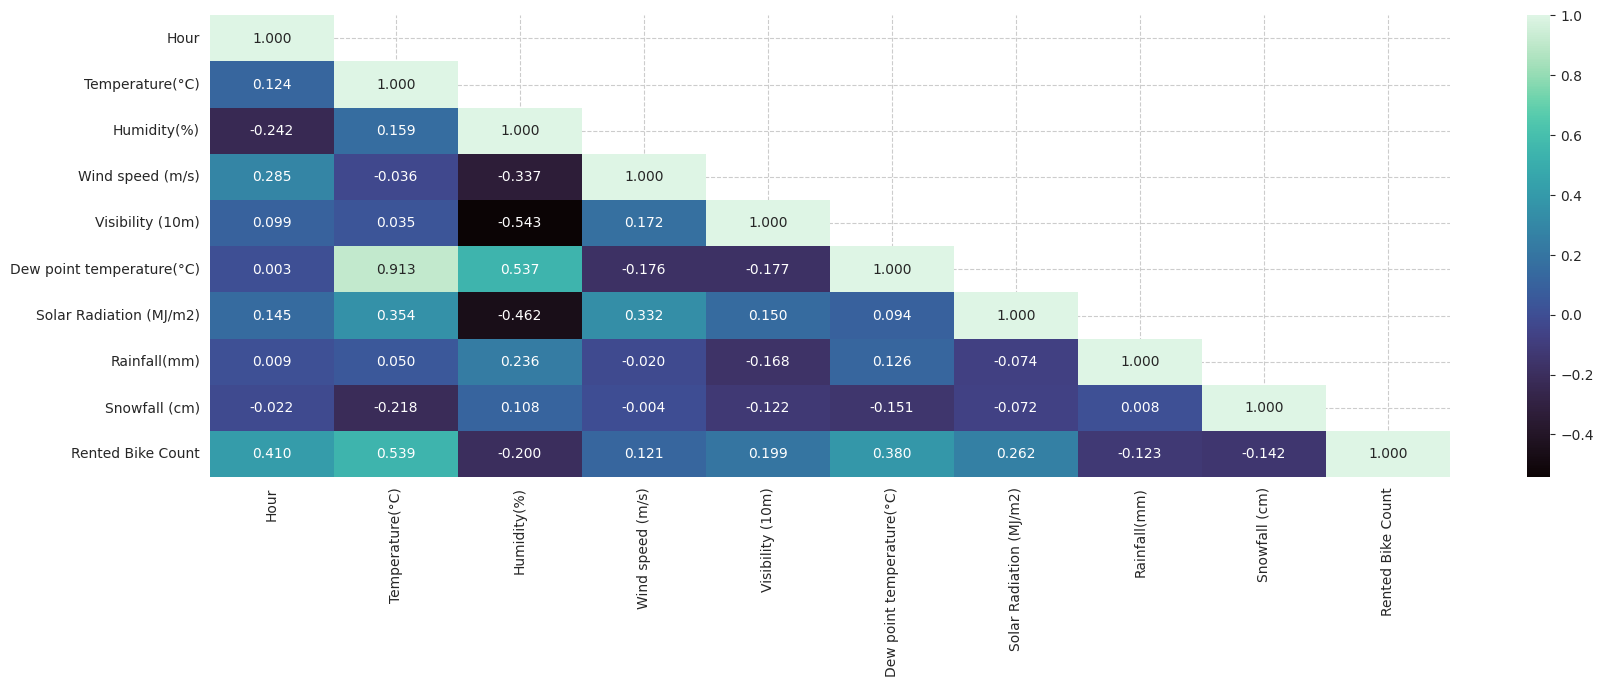

In [ ]:
corr = data.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr, annot = True, fmt='.3f',mask=mask, cmap='mako',cbar=True )

The temperature and dew point temperature features are highly correlated which my create difficulties in model interpretation after training, so we may need to drop one of them.

## **Hypothesis Testing**

Based on the exploratory analysis conducted using charts, we formulated three hypothetical statements about the dataset and subsequently conducted hypothesis testing through code and statistical methods to draw conclusive results regarding these statements.

In [ ]:
from scipy.stats import ttest_ind, f_oneway

**1: Rented Bike Demand in hot weather is higher compared to demand in cold weather.**

In [ ]:
hot_temps = df[df['Temperature(°C)'] >= 20]['Rented Bike Count']
cold_temps = df[df['Temperature(°C)'] < 20]['Rented Bike Count']
print('Null Hypothesis : Rented Bike Demand in hot weather is higher compared to demand in cold weather.')
print('Alternate Hypothesis : No significant difference in demand for Bike rentals in hot weather compared to demand in cold weather.\n')
print("Test Type : Two-sample T-test")
print('alpha = 0.05')
# Perform the t-test
t_stat, p_val = ttest_ind(hot_temps, cold_temps, equal_var=False)
print('Test Statistic :',t_stat)
print('p-value :',p_val)
print()
if p_val < 0.05:
    print("Since p-value is less than 0.05, we reject null hypothesis.")
    print("ie, Rented Bike Demand in hot weather is higher compared to demand in cold weather.")
else:
    print("Since p-value is greater than 0.05, we fail to reject null hypothesis.")
    print("ie, There is no significant difference in demand for bike rentals in hot weather compared to demand in cold weather.")

Null Hypothesis : Rented Bike Demand in hot weather is higher compared to demand in cold weather.
Alternate Hypothesis : No significant difference in demand for Bike rentals in hot weather compared to demand in cold weather.

Test Type : Two-sample T-test
alpha = 0.05
Test Statistic : 42.27606983032126
p-value : 0.0

Since p-value is less than 0.05, we reject null hypothesis.
ie, Rented Bike Demand in hot weather is higher compared to demand in cold weather.


**2. Rented Bike Demand during rush hour (7-9AM & 5-7PM)
is higher compared to non-rush hour.**

In [ ]:
# Create subsets of the data based on hour
rush_hour = df[(df['Hour'] >= 7) & (df['Hour'] <= 9) | (df['Hour'] >= 17) & (df['Hour'] <= 19)]['Rented Bike Count']
non_rush_hour = df[~((df['Hour'] >= 7) & (df['Hour'] <= 9) | (df['Hour'] >= 17) & (df['Hour'] <= 19))]['Rented Bike Count']
print('Null Hypothesis : Rented Bike Demand during rush hour (7-9AM & 5-7PM) is higher compared to non-rush hour.')
print('Alternate Hypothesis : No significant difference in demand for bike rentals during rush hour (7-9 AM & 5-7 PM) compared to demand in non-rush hour.\n')
print("Test Type : Two-sample T-test")
print('alpha = 0.05')

# Perform the t-test
t_stat, p_val = ttest_ind(rush_hour, non_rush_hour, equal_var=False)
print('Test Statistic :',t_stat)
print('p-value :',p_val)
print()
if p_val < 0.05:
    print("Since p-value is less than 0.05, we reject null hypothesis.")
    print("ie, Rented Bike Demand during rush hour (7-9 AM & 5-7 PM) and non-rush hour are different.")
else:
    print("Since p-value is greater than 0.05, we fail to reject null hypothesis.")
    print("ie, There is no significant difference in demand for bike rentals during rush hour (7-9 AM & 5-7 PM) compared to demand in non-rush hour")

Null Hypothesis : Rented Bike Demand during rush hour (7-9 AM & 5-7 PM) and non-rush hour are different.
Alternate Hypothesis : No significant difference in demand for bike rentals during rush hour (7-9 AM & 5-7 PM) compared to demand in non-rush hour.

Test Type : Two-sample T-test
alpha = 0.05
Test Statistic : 22.542388723325413
p-value : 9.381784283723713e-104

Since p-value is less than 0.05, we reject null hypothesis.
ie, Rented Bike Demand during rush hour (7-9 AM & 5-7 PM) and non-rush hour are different.


**3. Rented Bike Demand is different in different seasons with highest in summer and lowest in winter.**

In [ ]:
print('Null Hypothesis :  Rented Bike Demand is different in different seasons with highest in summer and lowest in winter.')
print('Alternate Hypothesis : No significant difference in demand for bike rentals in different seasons with highest in summer and lowest in winter.\n')
print('Test Type : One-way ANOVA test')
print('alpha = 0.05')
# Conduct the ANOVA test
f_stat, p_value = f_oneway(df.loc[df['Seasons']=='Spring', 'Rented Bike Count'],
                            df.loc[df['Seasons']=='Summer', 'Rented Bike Count'],
                            df.loc[df['Seasons']=='Autumn', 'Rented Bike Count'],
                            df.loc[df['Seasons']=='Winter', 'Rented Bike Count'])
print('Test Statistic :',f_stat)
print('p-value :',p_value)
print()
if p_value < 0.05:
    print("Since p-value is less than 0.05, we reject null hypothesis.")
    print("ie, Rented Bike Demand is different in different seasons with highest in summer and lowest in winter.")
else:
    print("Since p-value is greater than 0.05, we fail to reject null hypothesis.")
    print("ie, There is no significant difference in demand for bike rentals in different seasons with highest in summer and lowest in winter.")


Null Hypothesis :  Rented Bike Demand is different in different seasons with highest in summer and lowest in winter.
Alternate Hypothesis : No significant difference in demand for bike rentals in different seasons with highest in summer and lowest in winter.

Test Type : One-way ANOVA test
alpha = 0.05
Test Statistic : 776.4678149879506
p-value : 0.0

Since p-value is less than 0.05, we reject null hypothesis.
ie, Rented Bike Demand is different in different seasons with highest in summer and lowest in winter.


## **Feature Engineering & Data Pre-processing**

### 1. Handling Missing Values

In [ ]:
# Checking missing values
df.isna().sum().sum()

0

There are no missing values to handle in the given dataset.

In [ ]:
# From chart 16 above, we know following columns have outliers
outlier_cols = ['Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

In [ ]:
# Upper & Lower Boundary using IQR method
def getOutlierBoundaryIQR(df, feature):
  IQR= df[feature].quantile(0.75)- df[feature].quantile(0.25)
  lower_bridge =df[feature].quantile(0.25)-3*IQR
  upper_bridge =df[feature].quantile(0.75)+3*IQR
  return upper_bridge,lower_bridge

In [ ]:
# Upper & Lower boundary for Rainfall(mm) using IQR method
ub, lb = getOutlierBoundaryIQR(df, 'Rainfall(mm)')
print(f"Boundary: [{ub}, {lb}]")
# Applying outlier capping using 99th percentile
rainfall_99th = df['Rainfall(mm)'].quantile(0.99)
df['Rainfall(mm)_capped'] = df['Rainfall(mm)'].clip(upper=rainfall_99th)

Boundary: [0.0, 0.0]


In [ ]:
# Upper & Lower boundary using IQR method
ub, lb = getOutlierBoundaryIQR(df, 'Snowfall (cm)')
print(f"Boundary: [{ub}, {lb}]")
# Applying outlier capping using 99th percentile
snowfall_99th = df['Snowfall (cm)'].quantile(0.99)
df['Snowfall(cm)_capped'] = df['Snowfall (cm)'].clip(upper=snowfall_99th)

Boundary: [0.0, 0.0]


In [ ]:
# Upper & Lower boundary using IQR method for Wind Speed (m/s)
ub, lb = getOutlierBoundaryIQR(df, 'Wind speed (m/s)')
print(f"Boundary: [{ub}, {lb}]")
# Applying outlier capping using IQR outer fence
ub, lb = getOutlierBoundaryIQR(df, 'Wind speed (m/s)')
df['Wind speed (m/s)_capped'] = df['Wind speed (m/s)'].clip(lower=lb, upper=ub)

Boundary: [6.499999999999999, -3.2999999999999994]


In [ ]:
# Upper & Lower boundary using IQR method for Solar Radiation (MJ/m2)
ub, lb = getOutlierBoundaryIQR(df, 'Solar Radiation (MJ/m2)')
print(f"Boundary: [{ub}, {lb}]")
# Applying outlier capping using IQR outer fence
ub, lb = getOutlierBoundaryIQR(df, 'Solar Radiation (MJ/m2)')
df['Solar Radiation (MJ/m2)_capped'] = df['Solar Radiation (MJ/m2)'].clip(lower=lb, upper=ub)

Boundary: [3.72, -2.79]


-------------------------------------------------------------------------------
----------------------------------------------------------------------------

In [ ]:
df_copy = df.copy()

In [ ]:
def replace_season(season):
    #Function to change season to number

    if season =='Summer':
        return 1.0
    elif season =='Winter':
        return 2.0
    elif season =='Spring':
        return 3.0
    else:
        return 4.0

df_copy['Seasons'] = df_copy['Seasons'].apply(replace_season)

In [ ]:
def replace_weekday(weekday):

    if weekday =='Sunday':
        return 1.0
    elif weekday=='Monday':
        return 2.0
    elif weekday=='Tuesday':
        return 3.0
    elif weekday=='Wednesday':
        return 4.0
    elif weekday=='Thursday':
        return 5.0
    elif weekday =='Friday':
        return 6.0
    else:
        return 7.0
df_copy['weekday'] = df_copy['weekday'].apply(replace_weekday)

In [ ]:
def replace_holiday(holiday):
    if holiday =='No Holiday':
        return 0.0
    else:
        return 1.0
df_copy['Holiday'] = df_copy['Holiday'].apply(replace_holiday)

In [ ]:
# Function to distribute hour
def distribute_hour(h):
    if 17 <= h <= 22:
        return 'Evening'
    elif 7 <= h <= 10:
        return 'Morning'
    elif 11 <= h <= 16:
        return 'Noon'
    else:
        return 'Night'

hour_map = {'Night': 1,"Morning":2,"Afternoon":3, "Evening":4}

# Apply the hour function
df_copy['Hour'] = df_copy['Hour'].apply(distribute_hour).map(hour_map)



In [ ]:
bike_df = df_copy[['Temperature(°C)','Humidity(%)','Wind speed (m/s)_capped','Solar Radiation (MJ/m2)_capped','Month','weekday','Hour','Holiday','Seasons','Rented Bike Count' ]]
bike_df['Month'] = bike_df['Month'].astype('float64')
column_name_mapping = {'Wind speed (m/s)_capped': 'Wind speed (m/s)','Solar Radiation (MJ/m2)_capped': 'Solar Radiation (MJ/m2)','weekday': 'Weekday'}

# Use the rename method to rename columns
bike_df.rename(columns=column_name_mapping, inplace=True)
bike_df.to_csv('bike_demand.csv', index=False)
bike_df.head()

Temperature(°C)  Humidity(%)  Wind speed (m/s)  Solar Radiation (MJ/m2)  \
0             -5.2           37               2.2                      0.0   
1             -5.5           38               0.8                      0.0   
2             -6.0           39               1.0                      0.0   
3             -6.2           40               0.9                      0.0   
4             -6.0           36               2.3                      0.0   

   Month  Weekday  Hour  Holiday  Seasons  Rented Bike Count  
0   12.0      6.0   1.0      0.0      2.0                254  
1   12.0      6.0   1.0      0.0      2.0                204  
2   12.0      6.0   1.0      0.0      2.0                173  
3   12.0      6.0   1.0      0.0      2.0                107  
4   12.0      6.0   1.0      0.0      2.0                 78

In [ ]:
df.head()

Date  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0 2017-12-01     0             -5.2           37               2.2   
1 2017-12-01     1             -5.5           38               0.8   
2 2017-12-01     2             -6.0           39               1.0   
3 2017-12-01     3             -6.2           40               0.9   
4 2017-12-01     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day  \
0           0.0            0.0  Winter  No Holiday             Yes   
1           0.0            0.0  Winter  No Holiday             Yes   
2           0.0            0.0  Winter  No Holiday             Yes   
3           0.0            0.0  Winter  No Holiday             Yes   
4           0.0            0.0  Winter  No Holiday             Yes   

   Rented Bike Count  Year Month Day weekday  Temperature Bin  \
0                254  2017    12   1  Friday               -5   
1                204  2017    12   1  Friday               -6   
2                173  2017    12   1  Friday               -6   
3                107  2017    12   1  Friday               -6   
4                 78  2017    12   1  Friday               -6   

   Rainfall(mm)_capped  Snowfall(cm)_capped  Wind speed (m/s)_capped  \
0                  0.0                  0.0                      2.2   
1                  0.0                  0.0                      0.8   
2                  0.0                  0.0                      1.0   
3                  0.0                  0.0                      0.9   
4                  0.0                  0.0                      2.3   

   Solar Radiation (MJ/m2)_capped  
0                             0.0  
1                             0.0  
2                             0.0  
3                             0.0  
4                             0.0

In [ ]:
# Below categorical columns needs encoding using one hot encoding
d = df[['Seasons', 'Holiday','Functioning Day', 'Month', 'weekday']]
encoded_df = pd.get_dummies(d, drop_first=True)
df = pd.concat([df, encoded_df], axis=1)
df.head(2)

Date  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0 2017-12-01     0             -5.2           37               2.2   
1 2017-12-01     1             -5.5           38               0.8   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day  \
0           0.0            0.0  Winter  No Holiday             Yes   
1           0.0            0.0  Winter  No Holiday             Yes   

   Rented Bike Count  Year Month Day weekday  Temperature Bin  \
0                254  2017    12   1  Friday               -5   
1                204  2017    12   1  Friday               -6   

   Rainfall(mm)_capped  Snowfall(cm)_capped  Wind speed (m/s)_capped  \
0                  0.0                  0.0                      2.2   
1                  0.0                  0.0                      0.8   

   Solar Radiation (MJ/m2)_capped  Seasons_Spring  Seasons_Summer  \
0                             0.0               0               0   
1                             0.0               0               0   

   Seasons_Winter  Holiday_No Holiday  Functioning Day_Yes  Month_2  Month_3  \
0               1                   1                    1        0        0   
1               1                   1                    1        0        0   

   Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
0        0        0        0        0        0        0         0         0   
1        0        0        0        0        0        0         0         0   

   Month_12  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0         1               0                 0               0   
1         1               0                 0               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  
0                 0                0                  0  
1                 0                0                  0

#### 1. Feature Manipulation

In [ ]:
# is_weekend feature can help capture any weekday/weekend patterns in the bike rental demand.
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)

In [ ]:
df.groupby('Functioning Day')['Rented Bike Count'].sum()

Functioning Day
No           0
Yes    6172314
Name: Rented Bike Count, dtype: int64

In [ ]:
# Removing data of non functional days (non rented days)
df = df.drop(df[df['Functioning Day'] == 'No'].index)

# Since all values in Functioning Day Column is same, removing Functioning Day Column
df = df.drop(['Functioning Day'], axis = 1)

In [ ]:
# Features selected for modelling which includes:
# 1. Numerical (Continuous) Features
# 2. Encoded Categorical Features
filtered_features = ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Rainfall(mm)_capped', 'Snowfall(cm)_capped', 'Wind speed (m/s)_capped',
       'Solar Radiation (MJ/m2)_capped', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Holiday_No Holiday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'is_weekend'] #'prev_rented_bike_count'

df2 = df[filtered_features]
df2.head(2)

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Visibility (10m)  \
0                254     0             -5.2           37              2000   
1                204     1             -5.5           38              2000   

   Dew point temperature(°C)  Rainfall(mm)_capped  Snowfall(cm)_capped  \
0                      -17.6                  0.0                  0.0   
1                      -17.6                  0.0                  0.0   

   Wind speed (m/s)_capped  Solar Radiation (MJ/m2)_capped  Seasons_Spring  \
0                      2.2                             0.0               0   
1                      0.8                             0.0               0   

   Seasons_Summer  Seasons_Winter  Holiday_No Holiday  Month_2  Month_3  \
0               0               1                   1        0        0   
1               0               1                   1        0        0   

   Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
0        0        0        0        0        0        0         0         0   
1        0        0        0        0        0        0         0         0   

   Month_12  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0         1               0                 0               0   
1         1               0                 0               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  is_weekend  
0                 0                0                  0           0  
1                 0                0                  0           0

In [ ]:
# Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif.sort_values(by='VIF', ascending=False)

In [ ]:
calc_vif(df2.select_dtypes(include=['float','int']).drop('Rented Bike Count', axis=1))

feature        VIF
1                 Temperature(°C)  33.678675
4       Dew point temperature(°C)  17.629784
3                Visibility (10m)   9.157289
2                     Humidity(%)   5.803109
7         Wind speed (m/s)_capped   4.837381
0                            Hour   4.419686
8  Solar Radiation (MJ/m2)_capped   2.866329
9                      is_weekend   1.416439
5             Rainfall(mm)_capped   1.174577
6             Snowfall(cm)_capped   1.150386

In [ ]:
# Dew Point Temperature is highly correlated, hence dropping Dew point Temperature
del df2['Dew point temperature(°C)']

In [ ]:
calc_vif(df2.select_dtypes(include=['float','int']).drop(['Rented Bike Count'], axis=1))

feature       VIF
2                     Humidity(%)  5.238139
3                Visibility (10m)  4.859556
6         Wind speed (m/s)_capped  4.633048
0                            Hour  3.955038
1                 Temperature(°C)  3.216633
7  Solar Radiation (MJ/m2)_capped  2.246156
8                      is_weekend  1.386784
4             Rainfall(mm)_capped  1.170751
5             Snowfall(cm)_capped  1.150254

Text(0.5, 1.0, 'Rented Bike Count (sqrt) Distribution')

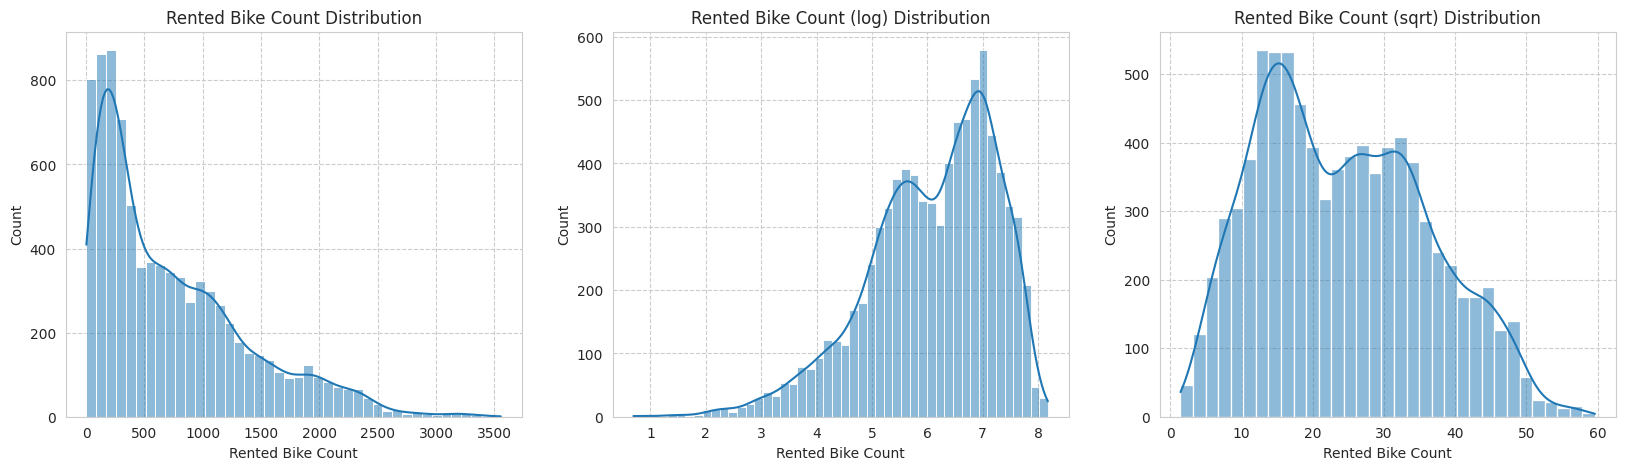

In [ ]:
# Transforming 'Rented Bike Count' to normal
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.histplot(x='Rented Bike Count', data=df2, kde=True)
plt.title("Rented Bike Count Distribution")

plt.subplot(1,3,2)
sns.histplot(np.log(df2['Rented Bike Count']), kde=True)
plt.title("Rented Bike Count (log) Distribution")

plt.subplot(1,3,3)
sns.histplot(np.sqrt(df2['Rented Bike Count']), kde=True)
plt.title("Rented Bike Count (sqrt) Distribution")

In [ ]:
# Transforming Rented Bike Count using np.sqrt
df2['Rented Bike Count'] = np.sqrt(df2['Rented Bike Count'])

In [ ]:
# Transforming Wind Speed using np.sqrt
df2['Wind speed (m/s)_capped'] = np.sqrt(df2['Wind speed (m/s)_capped'])

In [ ]:
# Standardizing the required column
df2['Temperature(°C)'] = StandardScaler().fit_transform(df2['Temperature(°C)'].values.reshape(-1, 1))
df2['Humidity(%)'] = StandardScaler().fit_transform(df2['Humidity(%)'].values.reshape(-1, 1))

# Normalizing the required column
df2['Visibility (10m)'] = MinMaxScaler().fit_transform(df2['Visibility (10m)'].values.reshape(-1, 1))

In [ ]:
# Processed Dataset shape (rows, columns)
df2.head()

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Visibility (10m)  \
0          15.937377     0        -1.484762    -1.032395               1.0   
1          14.282857     1        -1.509548    -0.983575               1.0   
2          13.152946     2        -1.550858    -0.934756               1.0   
3          10.344080     3        -1.567382    -0.885937               1.0   
4           8.831761     4        -1.550858    -1.081214               1.0   

   Rainfall(mm)_capped  Snowfall(cm)_capped  Wind speed (m/s)_capped  \
0                  0.0                  0.0                 1.483240   
1                  0.0                  0.0                 0.894427   
2                  0.0                  0.0                 1.000000   
3                  0.0                  0.0                 0.948683   
4                  0.0                  0.0                 1.516575   

   Solar Radiation (MJ/m2)_capped  Seasons_Spring  Seasons_Summer  \
0                             0.0               0               0   
1                             0.0               0               0   
2                             0.0               0               0   
3                             0.0               0               0   
4                             0.0               0               0   

   Seasons_Winter  Holiday_No Holiday  Month_2  Month_3  Month_4  Month_5  \
0               1                   1        0        0        0        0   
1               1                   1        0        0        0        0   
2               1                   1        0        0        0        0   
3               1                   1        0        0        0        0   
4               1                   1        0        0        0        0   

   Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  Month_12  \
0        0        0        0        0         0         0         1   
1        0        0        0        0         0         0         1   
2        0        0        0        0         0         0         1   
3        0        0        0        0         0         0         1   
4        0        0        0        0         0         0         1   

   weekday_Monday  weekday_Saturday  weekday_Sunday  weekday_Thursday  \
0               0                 0               0                 0   
1               0                 0               0                 0   
2               0                 0               0                 0   
3               0                 0               0                 0   
4               0                 0               0                 0   

   weekday_Tuesday  weekday_Wednesday  is_weekend  
0                0                  0           0  
1                0                  0           0  
2                0                  0           0  
3                0                  0           0  
4                0                  0           0

In [ ]:
df2.shape

(8465, 31)

In [ ]:
df2.to_csv('bike_dataset.csv', index=False)

In [ ]:
# Splitting data into 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(df2.drop("Rented Bike Count", axis=1), df2["Rented Bike Count"], test_size = 0.25, random_state = 0)

# describes info about train and test set
print("For Train data :  ", X_train.shape,y_train.shape)
print("For Test data :  ",X_test.shape,y_test.shape)

For Train data :   (6348, 30) (6348,)
For Test data :   (2117, 30) (2117,)


In [ ]:
# Dictionary to store different models accuracies
model_results = {}

**Linear Regression Model**

In [ ]:
# Linear regression with hyperparameter tuning
model_lr_cv = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(model_lr_cv, params, cv=5, scoring='neg_mean_squared_error')

# Fit the Algorithm
grid_search.fit(X_train, y_train)
linear_reg_cv = grid_search.best_estimator_

# Predict on the model
train_preds = linear_reg_cv.predict(X_train)
test_preds = linear_reg_cv.predict(X_test)

mse_lr_tr = mean_squared_error(y_train, train_preds).round(3)
mae_lr_tr = mean_absolute_error(y_train, train_preds).round(3)
r2_lr_tr =  r2_score(y_train, train_preds).round(3)
print("Training Data:")
print("  > MSE:", mse_lr_tr)
print("  > MAE:", mae_lr_tr)
print("  > R2 Score:", r2_lr_tr)

mse_lr_ts = mean_squared_error(y_test, test_preds)
mae_lr_ts = mean_absolute_error(y_test, test_preds)
r2_lr_ts = r2_score(y_test, test_preds)
print("\nTesting Data:")
print("  > MSE:", mse_lr_ts.round(3))
print("  > MAE:", mae_lr_ts.round(3))
print("  > R2 Score:", r2_lr_ts.round(3))

Training Data:
  > MSE: 46.134
  > MAE: 5.206
  > R2 Score: 0.673

Testing Data:
  > MSE: 45.506
  > MAE: 5.148
  > R2 Score: 0.672


In [ ]:
# Storing model performance for comparision later
model_results['Linear Regression'] = [r2_lr_ts, mse_lr_ts, mae_lr_ts]

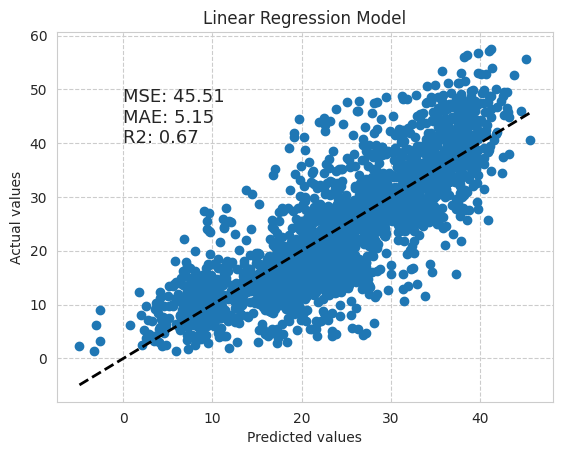

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Linear Regression Model')

# Add evaluation metrics to plot
plt.text(0, 40, f'MSE: {mse_lr_ts:.2f}\nMAE: {mae_lr_ts:.2f}\nR2: {r2_lr_ts:.2f}', fontsize=13, ha='left')

plt.show()

**Decision Tree Model**

In [ ]:
params = {'max_depth': np.arange(1, 10), 'min_samples_leaf': [1, 2, 4, 8, 16]}

dtree_cv = DecisionTreeRegressor(random_state=1)
grid_search = GridSearchCV(dtree_cv, params, cv=5, scoring='neg_mean_squared_error')

# Fit the Algorithm
grid_result = grid_search.fit(X_train, y_train)
dtree_cv = grid_search.best_estimator_

# Predict on the model
train_preds = dtree_cv.predict(X_train)
test_preds = dtree_cv.predict(X_test)

mse_dt_tr = mean_squared_error(y_train, train_preds).round(3)
mae_dt_tr = mean_absolute_error(y_train, train_preds).round(3)
r2_dt_tr =  r2_score(y_train, train_preds).round(3)
print("Training Data:")
print("  > MSE:", mse_dt_tr)
print("  > MAE:", mae_dt_tr)
print("  > R2 Score:", r2_dt_tr)

mse_dt_ts = mean_squared_error(y_test, test_preds)
mae_dt_ts = mean_absolute_error(y_test, test_preds)
r2_dt_ts = r2_score(y_test, test_preds)
print("\nTesting Data:")
print("  > MSE:", mse_dt_ts.round(3))
print("  > MAE:", mae_dt_ts.round(3))
print("  > R2 Score:", r2_dt_ts.round(3))

Training Data:
  > MSE: 13.408
  > MAE: 2.493
  > R2 Score: 0.905

Testing Data:
  > MSE: 22.35
  > MAE: 3.123
  > R2 Score: 0.839


In [ ]:
model_results['Decision Tree '] = [r2_dt_ts, mse_dt_ts, mae_dt_ts]

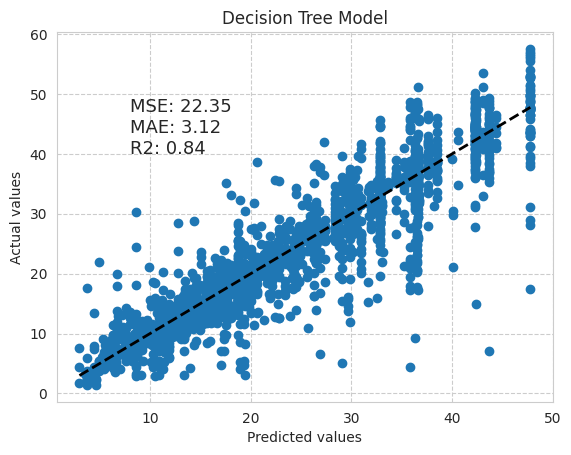

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Decision Tree Model')

# Add evaluation metrics to plot
plt.text(8, 40, f'MSE: {mse_dt_ts:.2f}\nMAE: {mae_dt_ts:.2f}\nR2: {r2_dt_ts:.2f}', fontsize=13, ha='left')

plt.show()

**Random Forest Model**

In [ ]:
rf_model = RandomForestRegressor(random_state=1)

# Fit the Algorithm
rf_model.fit(X_train, y_train)

# Predict on the model
train_preds = rf_model.predict(X_train)
test_preds = rf_model.predict(X_test)

mse_rf_tr = mean_squared_error(y_train, train_preds).round(3)
mae_rf_tr = mean_absolute_error(y_train, train_preds).round(3)
r2_rf_tr =  r2_score(y_train, train_preds).round(3)
print("Training Data:")
print("  > MSE:", mse_rf_tr)
print("  > MAE:", mae_rf_tr)
print("  > R2 Score:", r2_rf_tr)

mse_rf_ts = mean_squared_error(y_test, test_preds)
mae_rf_ts = mean_absolute_error(y_test, test_preds)
r2_rf_ts = r2_score(y_test, test_preds)
print("\nTesting Data:")
print("  > MSE:", mse_rf_ts.round(3))
print("  > MAE:", mae_rf_ts.round(3))
print("  > R2 Score:", r2_rf_ts.round(3))

Training Data:
  > MSE: 1.238
  > MAE: 0.703
  > R2 Score: 0.991

Testing Data:
  > MSE: 11.027
  > MAE: 2.031
  > R2 Score: 0.92


In [ ]:
model_results['Random Forest '] = [r2_rf_ts, mse_rf_ts, mae_rf_ts]

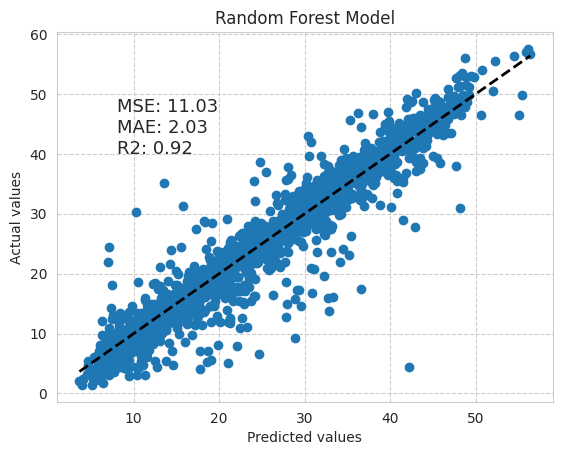

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random Forest Model')

# Add evaluation metrics to plot
plt.text(8, 40, f'MSE: {mse_rf_ts:.2f}\nMAE: {mae_rf_ts:.2f}\nR2: {r2_rf_ts:.2f}', fontsize=13, ha='left')

plt.show()

**XGBoost Model**

In [ ]:
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 6, 10, 12, 15],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    'n_estimators': [50, 100, 200, 300, 500],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}
xgb_model = XGBRegressor(random_state=1)
rand_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=50, cv=5, n_jobs=-1, random_state=1)

# Fit the Algorithm
rand_result = rand_search.fit(X_train, y_train)
xgb_model_cv = rand_search.best_estimator_

# Predict on the model
train_preds = xgb_model_cv.predict(X_train)
test_preds = xgb_model_cv.predict(X_test)

mse_xb_tr = mean_squared_error(y_train, train_preds).round(3)
mae_xb_tr = mean_absolute_error(y_train, train_preds).round(3)
r2_xb_tr =  r2_score(y_train, train_preds).round(3)
print("Training Data:")
print("  > MSE:", mse_xb_tr)
print("  > MAE:", mae_xb_tr)
print("  > R2 Score:", r2_xb_tr)

mse_xb_ts = mean_squared_error(y_test, test_preds)
mae_xb_ts = mean_absolute_error(y_test, test_preds)
r2_xb_ts = r2_score(y_test, test_preds)
print("\nTesting Data:")
print("  > MSE:", mse_xb_ts.round(3))
print("  > MAE:", mae_xb_ts.round(3))
print("  > R2 Score:", r2_xb_ts.round(3))

Training Data:
  > MSE: 0.029
  > MAE: 0.124
  > R2 Score: 1.0

Testing Data:
  > MSE: 8.377
  > MAE: 1.731
  > R2 Score: 0.94


In [ ]:
model_results['XGBoost '] = [r2_xb_ts, mse_xb_ts, mae_xb_ts]

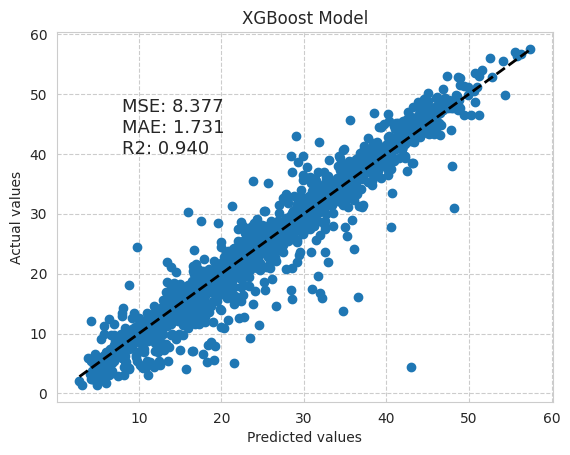

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('XGBoost Model')

# Add evaluation metrics to plot
plt.text(8, 40, f'MSE: {mse_xb_ts:.3f}\nMAE: {mae_xb_ts:.3f}\nR2: {r2_xb_ts:.3f}', fontsize=13, ha='left')

plt.show()

In [ ]:
Model_com_df = pd.DataFrame(model_results).T
Model_com_df.columns = ["R2", 'MSE', 'MAE']
Model_com_df = Model_com_df.sort_values(by='R2',ascending=False)
Model_com_df.style.format('{:.3f}').background_gradient(cmap='mako')

The XGBoost model seems to be the best choice for this dataset as it has the highest R2 score, the lowest MSE, and the lowest MAE with test data.

We can see that Hour and Temperature are the two most important feature to predict rental bike demand, then followed by Humidity, Season_Winter, Solar Radiation, Rainfall etc.

In [ ]:
# Save the model to a pickle file
with open("xgb_model.pkl", "wb") as f:
  pickle.dump(xgb_model_cv, f)

In [ ]:
# Load the model from the pickle file
with open("xgb_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

new_test_preds = loaded_xgb_model.predict(X_test)

# Sanity Check
mse = mean_squared_error(y_test, new_test_preds)
mae = mean_absolute_error(y_test, new_test_preds)
r2 = r2_score(y_test, new_test_preds)
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

MSE: 8.376912452084232
MAE: 1.7309521263306675
R2 Score: 0.9396029889731649
